# Notebook for implementing LIDAR NeRF in TensorFlow from scratch

### TODO:

* Regularization -- adjust loss function to discourage "floaters"
* Fix pinhole camera model
* Implement patch-wise structural regularization described in LiDAR-NeRF paper
* Scale vs Contract 


### ICEBOX:

* Add non-return mask
* Add intensity channel
* Account for platform motion

In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-03-21 09:28:03.062216: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-21 09:28:03.160394: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-21 09:28:03.571136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-21 09:28:03.571193: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-21 09:28:04.328024: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-21 09:28:04.328374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-21 09:28:04.328622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-21 09:28:04.666804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-21 09:28:04.666982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [2]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
# idx = 800 
# fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
# pc1 = np.load(fn1)
# pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention

# #KITTI-CARLA
# town = 'Town02'
# idx = 0
# s1_fn = '/home/derm/KITTICARLA/dataset/' + town + '/generated/frames/frame_%04d.ply' %(idx)
# dat1 = trimesh.load(s1_fn)
# pc1 = dat1.vertices
# pc1 = pc1[:140_224]
# noise_scale = 0.02 #need to add some noise or numerics can cause VICET and NDT to get stuck
# pc1 += noise_scale*np.random.randn(np.shape(pc1)[0],3)

#TODO: trim synthetic data to [0,2pi] theta

# # synthetic LIDAR data (VICET paper)
# fn1 = "raw_frame_1.npy"
# pc1 = np.load(fn1)

# fn1 = "/home/derm/ASAR/v3/point_cloud_rectification/sample_data/test1/raw_frame_1.npy"
# fn1 = "gazebo_scene/scan2.npy"
# fn1 = "gazebo_scene2/scan6.npy"
# fn1 = "gazebo_scene2/box_scan4.npy"
fn1 = "gazebo_scene2/box2_scan4.npy"
pc1 = np.load(fn1)
#remove inf values
pc1[pc1[:,0]>100] = 0
pc1[pc1[:,0]<-100] = 0
# noise_scale = 0.02 #need to add some noise or numerics can cause VICET and NDT to get stuck
# pc1 += noise_scale*np.random.randn(np.shape(pc1)[0],3)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


# #TEST--- add yaw to raw rotation to raw data
# theta = 0.5 #2*np.random.randn()
# yaw_rotm = R.from_euler('xyz', [0,0,theta]).as_matrix()
# pc1 = pc1 @ yaw_rotm
# #-------------------------------------------

## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

# test = pc1[::64]
# # # test = test[::64]
# disp.append(Points(test, c='red',r = 5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

1047.5


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image


[[ 2.13787937 -0.00004668  2.10608838]
 [ 2.19000715 -0.00004668  2.09463568]
 [ 2.26246525 -0.00004668  2.08318296]
 ...
 [ 9.05474974 -0.00592264  1.4074747 ]
 [ 9.08855832 -0.00592264  1.39602201]
 [ 9.09733469 -0.00592264  1.38456933]]
[    64     65     66 ... 134077 134078 134079]


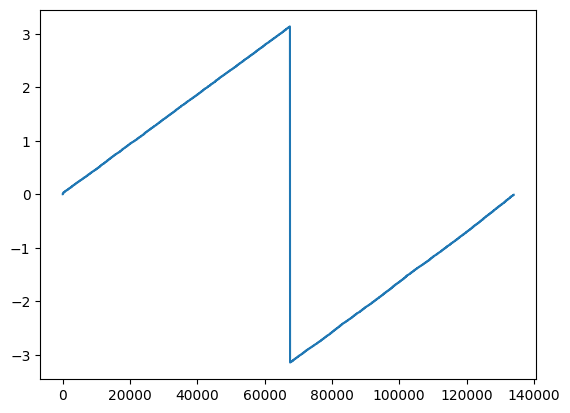

In [3]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi] --> theta = azimuth, phi = elevation
# print(np.shape(pc1_spherical))
print(pc1_spherical)

#TODO: make sure the depth image stays at exactly a 360deg sweep ~~~
#issue with points at the beginning of the scan starting with theta < 0
less_than_zero = np.where(pc1_spherical[:,1] < 0)[0]
less_than_zero = less_than_zero[less_than_zero[:] < len(pc1_spherical)//4]

# print(np.linspace(0,len(pc1_spherical)-1,len(pc1_spherical)))
good_idx = np.setdiff1d(np.linspace(0,len(pc1_spherical)-1,len(pc1_spherical), dtype = int), less_than_zero)

print(good_idx)
# %matplotlib notebook
fig, ax = p.subplots()
# ax.plot(less_than_zero)

pc1_spherical = pc1_spherical[good_idx]
ax.plot(pc1_spherical[:,1])
# ax.plot(np.diff(pc1_spherical[:,1]))
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

depth_image = np.zeros([64, len(pc1_spherical)//64])
# depth_image = np.zeros([128, len(pc1_spherical)//128])

#set points of radius zero (i.e. non returns) to large values
depth_image = pc1_spherical.copy()
non_return_idx = np.argwhere(depth_image == 0)
# print(non_return_idx)
depth_image[non_return_idx[:,0], non_return_idx[:,1]] = 10

In [4]:
# pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi] #test commenting out
pcs = np.reshape(pc1_spherical, [-1,64,3])
# pcs = np.reshape(pc1_spherical, [-1,128,3])
print(np.shape(pcs))
pcs = np.flip(pcs, axis = 1)

# pcs = pcs[np.argsort(pcs, axis = 1)[:,0,0]]
# print(np.shape(pcs))

(2094, 64, 3)


(64, 2094)


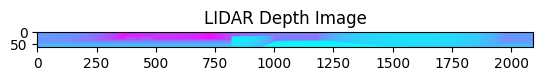

In [5]:
fig, ax = p.subplots()
ax.set_title("LIDAR Depth Image")
# data = pcs[650:850,:,0].T
data = pcs[:,:,0].T
# data = (data)%10 #add zebra stripes to make it easier to visualize depth
p.imshow(data, cmap = "cool", norm='linear')
print(np.shape(data))

# Reproject 2D Depth image back to 3D point cloud using same convention

In [6]:
#Get LiDAR Intrinsics
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
phimin = -0.53529248 #rad
phimax = 0.18622663 #rad

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(pcs)[0]):
    for h in range(np.shape(pcs)[1]):
        new_point_cloud_spherical[count,0] = pcs[w,h,0] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(pcs)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(pcs)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 
print(np.shape(new_point_cloud_cart))
print(new_point_cloud_cart)

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
print(vert_fov)
vert_fov/360
print((vert_fov/360)*np.shape(pcs)[0])

(134016, 3)
[[10.63507758  0.          2.003752  ]
 [10.67338143  0.          1.88662732]
 [10.67421103  0.          1.76291742]
 ...
 [ 5.29600401 -0.01589106 -2.90335871]
 [ 5.16562494 -0.01549985 -2.90809535]
 [ 5.01390271 -0.01504459 -2.89759938]]
41.33999984103539
240.46099907535586


In [7]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

color = 255*np.linspace(0,1,len(new_point_cloud_cart)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(new_point_cloud_cart, c=cname,  r = 3.5, alpha =0.5))
# disp.append(Points(new_point_cloud_cart, c='red',  r = 3.5, alpha =0.5))

disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [8]:
# #debug
# %matplotlib notebook
# fig, ax = p.subplots()
# ax.plot(pc1_spherical[:,1])
# # ax.plot(new_point_cloud_spherical[:,1])

# print(pc1_spherical[0])
# print(pc1_spherical[-1])

# # print(np.shape(new_point_cloud_cart))
# # print(np.shape(pc1))

# Load Gazebo Point Clouds and Convert to Image Training Data

##### NOTE: be careful with syncing pose and image indices!

7
(12, 7)


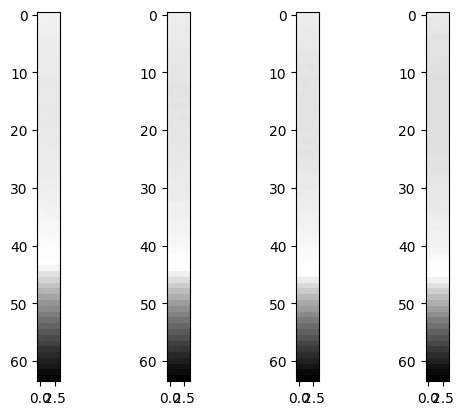

In [69]:
n_images =  10 #18 max for town, 11 max for old box, 16 for new box
# n_rots = 7 #7 #1 #number of side by side frames to add in
n_rots = 130 #60 for 1/8th (needs to be much bigger when we are splitting up range images vertically)

#achieve roughly same horizonal and vertical fov
vert_fov = np.rad2deg(phimax-phimin)
image_width = int((vert_fov/360)*np.shape(pcs)[0])
print(image_width)
# images = np.zeros([n_images, 64, image_width, 1])
# images = np.zeros([n_images*n_rots, 64, 64, 1]) #squares
# images = np.zeros([n_images*n_rots, 64, 8, 1]) #8 pixels wide
images = np.zeros([n_images*n_rots, 64, 4, 1]) #4 pixels wide
poses = np.zeros([n_images*n_rots,4,4])

# gtfn = "gazebo_scene/ground_truth.npy" #town
# gtfn = "gazebo_scene2/ground_truth.npy" #box v1
# gtfn = "gazebo_scene2/box_ground_truth.npy" #box v2
gtfn = "gazebo_scene2/box2_ground_truth.npy" #box v3
sensor_pose = np.load(gtfn)
# print(sensor_pose)
print(np.shape(sensor_pose))

for i in range(n_images):
    for j in range(n_rots):
        #load point cloud file
#         pcfn = "gazebo_scene/scan" + str(i+2) + ".npy" #town
#         pcfn = "gazebo_scene2/scan" + str(i+2) + ".npy" #box v1
#         pcfn = "gazebo_scene2/box_scan" + str(i+2) + ".npy" #box v2
        pcfn = "gazebo_scene2/box2_scan" + str(i+2) + ".npy" #box v3
        pc = np.load(pcfn)
        #cap inf values
        pc[pc[:,0]>64] = 32 #64 #0
        pc[pc[:,0]<-64] = 32 #64 #0

        #convert to image array
        pc_spherical = LC.c2s(LC,pc).numpy() #[r, theta, phi]
        pcs = np.reshape(pc_spherical, [-1,64,3])
        pcs = np.flip(pcs, axis = 1) #flip vertical
        pcs = np.flip(pcs, axis = 0) #flip horizontal to look at first clockwise patch of scan sweep 

        #resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0]) #(was this)
#         print(image_width)
#         pcs = pcs[0:image_width,:,0].T #just take from 12:00 to ~2:00
#         pcs = pcs[j*image_width:(j+1)*image_width,:,0] #iterate through different angles
        ##Important-- don't transpose this point cloud (even if the image looks sideways!)
        #             doing so will intriduce artifacts into image
#         pcs = pcs[j*image_width:(j+1)*image_width,:,0].T ##was this
#         pcs = pcs[(j*image_width//8):((j+1)*image_width//8),:,0].T #eighths
        pcs = pcs[(j*image_width//16):((j+1)*image_width//16),:,0].T #16ths

        pcs = cv2.resize(pcs, (64, 64)) #keep square
        #preserve aspect ratio and focal length but just take middle
#         pcs = pcs[:,28:36] #eighths
        pcs = pcs[:,30:34] #16ths
        images[j+(i*n_rots),:,:,0] = pcs

        #get sensor transformation matrix
        rotm = np.eye(4)
        rotm[0,3] = sensor_pose[i+1,0] #x
        rotm[2,3] = -sensor_pose[i+1,1] #y
        rotm[1,3] = -sensor_pose[i+1,2] #z
        rotm[:3,:3] = R.from_quat(sensor_pose[i+1,3:]).as_matrix() 
        
        #account for image crop in rotation
#         crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin) #"square"
#         crop_angle = -(phimax-phimin)/16 - j*(phimax-phimin)/8 #8-pixels wide
        crop_angle = -(phimax-phimin)/32 - j*(phimax-phimin)/16 #4-pixels wide
        rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #test
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

        #flip x and z axis
        rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

        # flip sign of y and z axis
        rotm[0:3,2] *= -1 
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:]
        rotm[2,:] *= -1 # flip whole world upside down
#         #translate all frames above xy plane
#         rotm[2,-1] += 25 #for town  
        rotm[2,-1] += 5 #for box (old)
#         rotm[2,-1] += 7 #for box (new)

# #         scale translations
#         rotm[:3,-1] *= 0.1
#         #scale ranges measurements?
#         images[j+(i*n_rots),:,:,0] *= 0.1
        
        poses[j+(i*n_rots)] = rotm

fig, ax = p.subplots(1,4)
ax[0].imshow(images[-4,:,:,0], cmap = "gray", norm='log')
ax[1].imshow(images[-3,:,:,0], cmap = "gray", norm='log')
ax[2].imshow(images[-2,:,:,0], cmap = "gray", norm='log')
ax[3].imshow(images[-1,:,:,0], cmap = "gray", norm='log')
# ax[0].set_aspect(4)
# ax[1].set_aspect(4)
# ax[2].set_aspect(4)
# ax[3].set_aspect(4)

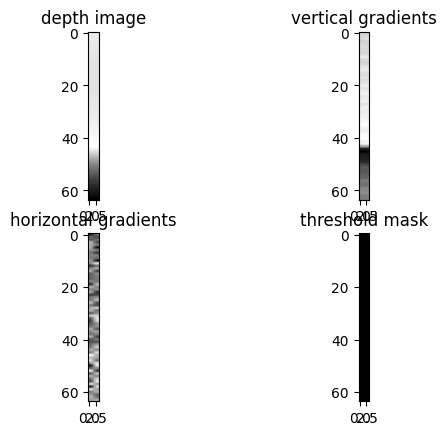

In [70]:
# LiDAR-NeRF Strucutral Regularization 

## Get Image Gradients
test_image = images[-4,:,:,0]
# print(test_image)

fig, ax = p.subplots(2,2)
ax[0,0].set_title("depth image")
ax[0,0].imshow(test_image, cmap = "gray", norm = 'linear')

vertical_grad = np.gradient(test_image)[0]
ax[0,1].set_title("vertical gradients")
ax[0,1].imshow(vertical_grad, cmap = "gray", norm = 'linear')

horizontal_grad = np.gradient(test_image)[1]
ax[1,0].set_title("horizontal gradients")
ax[1,0].imshow(horizontal_grad, cmap = "gray", norm = 'linear')

#mask gradients smaller than 0.1
thresh = 0.1
vertical_past_thresh = np.argwhere(vertical_grad > thresh)
horizontal_past_thresh = np.argwhere(horizontal_grad > thresh)
mask = np.zeros(np.shape(test_image))
mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 1
mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 1

ax[1,1].set_title("threshold mask")
ax[1,1].imshow(mask, cmap = "gray", norm = 'linear')

In [71]:
#Get LiDAR Intrinsics
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
phimin = -0.53529248 #rad
phimax = 0.18622663 #rad
#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
# focal = np.array(128/(2*np.tan((phimax-phimin)|/2))) #upscaling to 128x128??
H, W = images.shape[1:3]
print(focal, H, W)

images = images.astype(np.float32)
poses = poses.astype(np.float32)

# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

84.81983003899697 64 4


## Debug: Draw Training data in constant reference frame

In [72]:
#Simulated LIDAR Sensor -- (look for <min_angle> in velodyne.world file in ROS package)
phimin = -0.53529248 #rad
phimax = 0.18622663 #rad

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]


new_point_cloud_spherical = np.zeros([np.shape(images)[1]*np.shape(images)[2],3])

for i in range(9):
    #convert depth image back to point cloud
    count = 0
    for w in range(np.shape(images)[1]):
        for h in range(np.shape(images)[2]):
            new_point_cloud_spherical[count,0] = images[i,w,h,0] #radius
            new_point_cloud_spherical[count,1] = -(phimax-phimin)*(w/np.shape(images)[1]) #theta
#             new_point_cloud_spherical[count,1] = -(phimax-phimin)*(w/np.shape(images)[1])
#             new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2]) #phi
#             new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2])/8 
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2])/16 
            count+= 1
            
    #transform each to base frame using <poses>
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z -- does this indicate an error somewhere???
    disp.append(Points(new_point_cloud_cart, c='red',  r = 3.5, alpha =0.5))
    
#     #debug: draw origonal point cloud from scan i in blue ~~~~~~~~~
#     pcfn = "gazebo_scene2/scan" + str(i+2) + ".npy" #box
#     pc = np.load(pcfn)
#     disp.append(Points(pc, c = 'blue' ,r = 3.5, alpha=0.5))
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames for each sub-scan 
    #forward view direction (-z in NeRF c2w convention)
    headings = poses[i,:3,:3] @ np.array([0,0,-1])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "yellow"))
    # x
    headings = poses[i,:3,:3] @ np.array([1,0,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "red"))
    #y
    headings = poses[i,:3,:3] @ np.array([0,1,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "green"))
    #z
    headings = poses[i,:3,:3] @ np.array([0,0,1])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "blue"))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [73]:
# #debug coordinate system in <poses>
# #vedo
# from vedo import *
# from ipyvtklink.viewer import ViewInteractiveWidget
# plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True)
# disp=[]
# # disp.append(Points(poses[:,:3,-1], c = "#CB2314"))
# #forward view direction (-z in NeRF c2w convention)
# headings = poses[:,:3,:3] @ np.array([0,0,-1])
# disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "yellow"))
# #x
# headings = poses[:,:3,:3] @ np.array([1,0,0])
# disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "red"))
# #y
# headings = poses[:,:3,:3] @ np.array([0,1,0])
# disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "green"))
# #z
# headings = poses[:,:3,:3] @ np.array([0,0,1])
# disp.append(Arrows(poses[:,:3,-1], poses[:,:3,-1] + headings[:,:3], c = "blue"))
# disp.append(Points(np.array([[0,0,0]]), c = 'black'))
# plt.show(disp, "camera poses")
# ViewInteractiveWidget(plt.window)

# Train Vanilla TinyNeRF on depth image data 

In [74]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6 #6
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256): #8,256
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
#     outputs = dense(4, act=None)(outputs)
#     outputs = dense(2, act=None)(outputs) #"rgb" (single channel) + depth map
    outputs = dense(1, act=None)(outputs) #test

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=True):

    def batchify(fn, chunk=1024*128): #1024*32
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
#     print("pts",np.shape(pts))
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
#     raw = tf.reshape(raw, list(pts.shape[:-1]) + [2]) #two channel (old)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [1]) #depth only (new)

#     print(tf.shape(raw))
    
    # Compute opacities and colors
    #was this
#     sigma_a = tf.nn.relu(raw[...,3])
#     rgb = tf.math.sigmoid(raw[...,:3]) 
#     sigma_a = tf.nn.relu(raw[...,1]) #for depth only (old?)
#     rgb = tf.math.sigmoid(raw[...,0])[:,:,:,None] 
    sigma_a = tf.nn.relu(raw[...,0]) #test only looking at sigma
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
#     rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    rgb_map = tf.reduce_sum(weights * z_vals, -1) #test
    acc_map = tf.reduce_sum(weights, -1)

#     return rgb_map, depth_map, acc_map
    return depth_map, acc_map

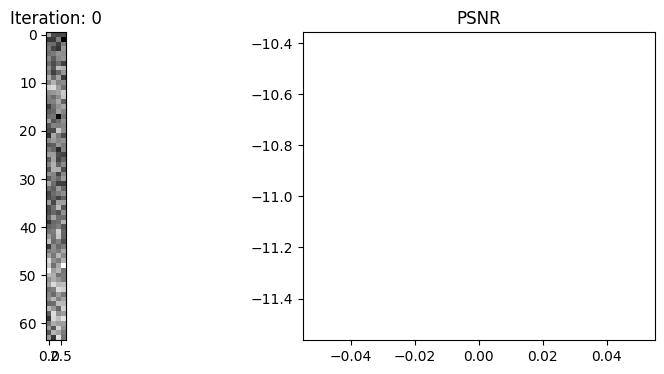

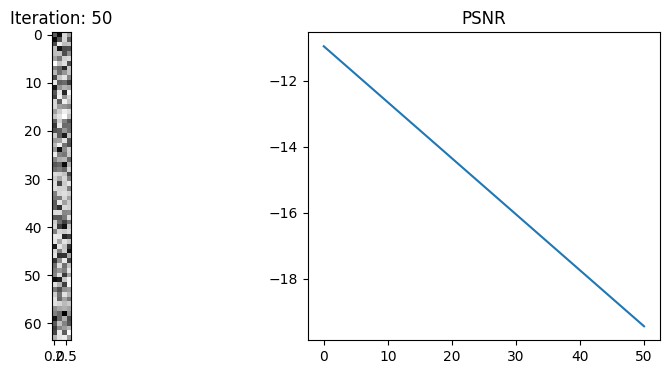

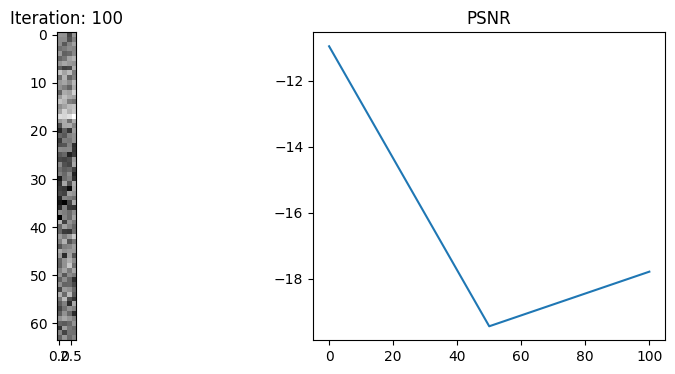

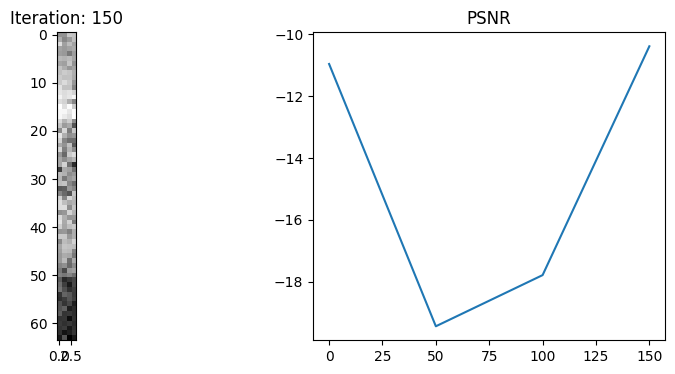

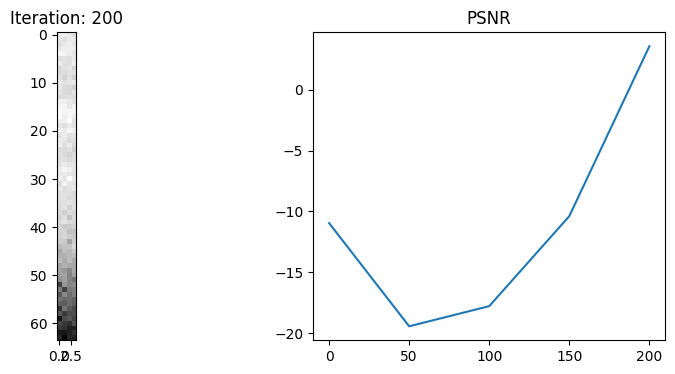

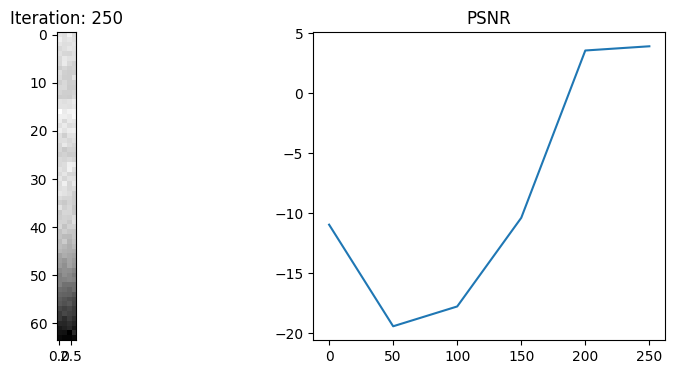

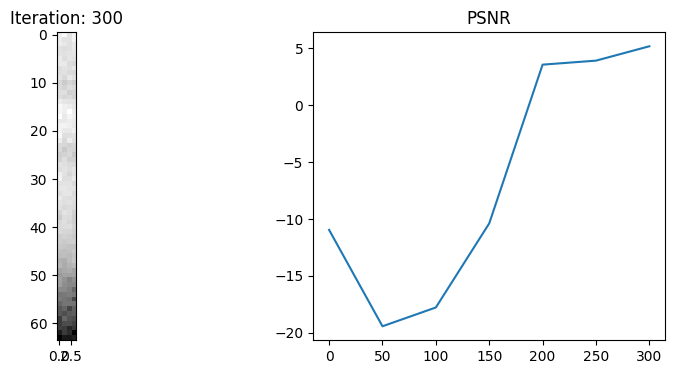

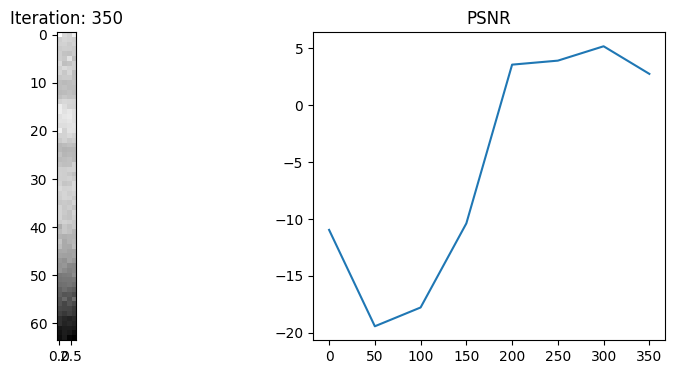

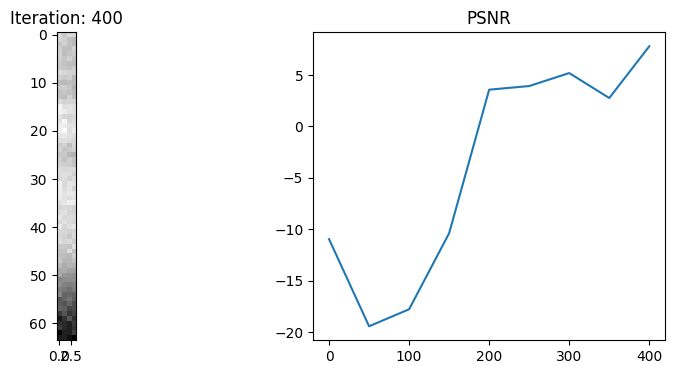

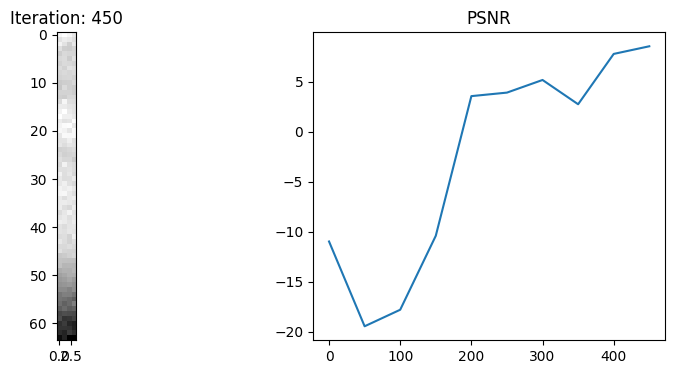

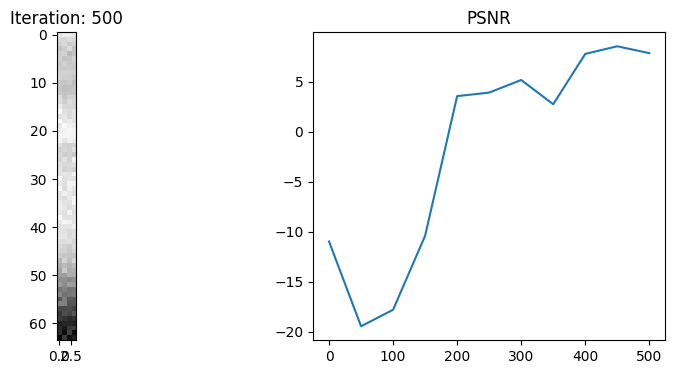

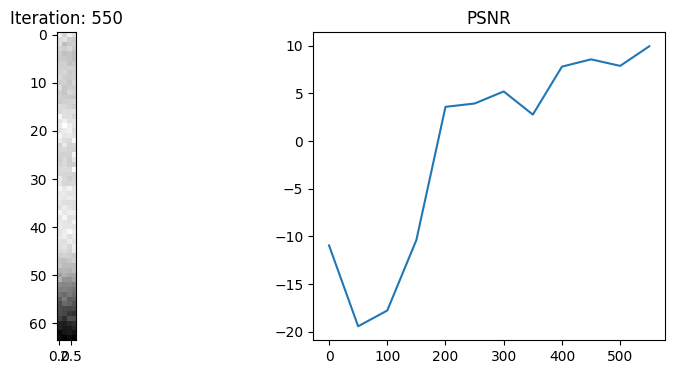

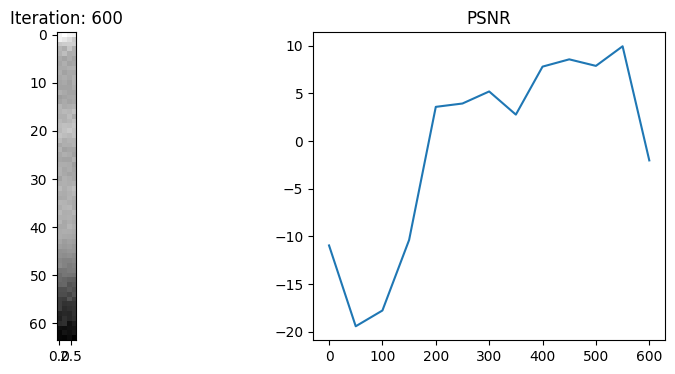

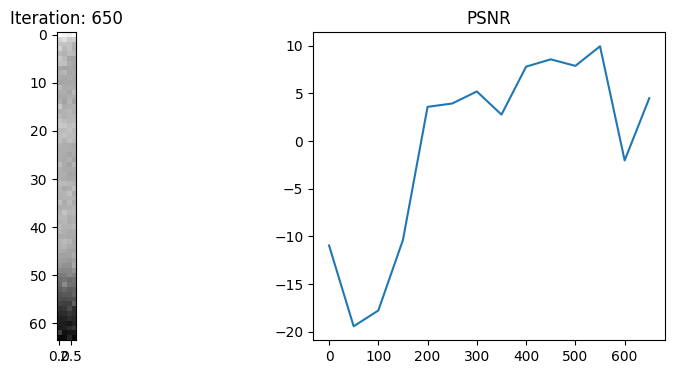

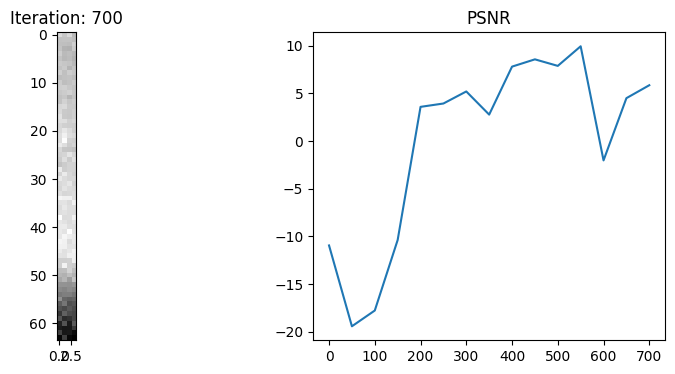

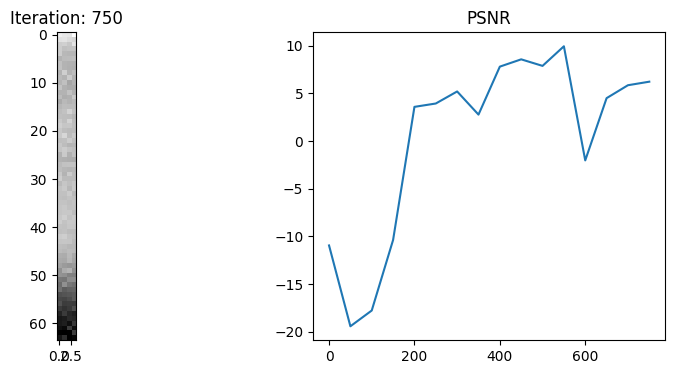

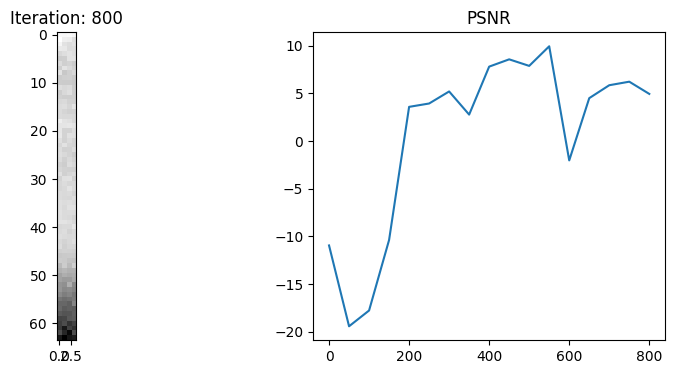

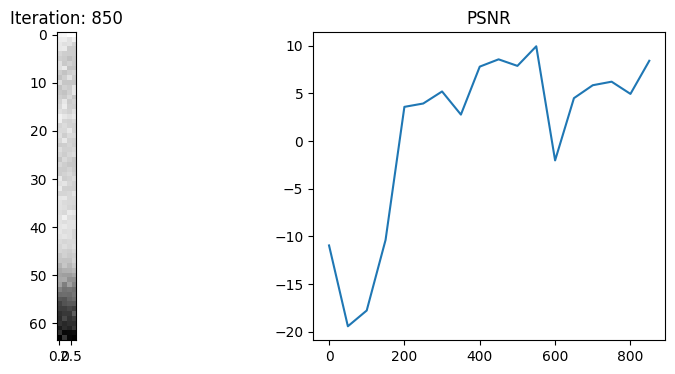

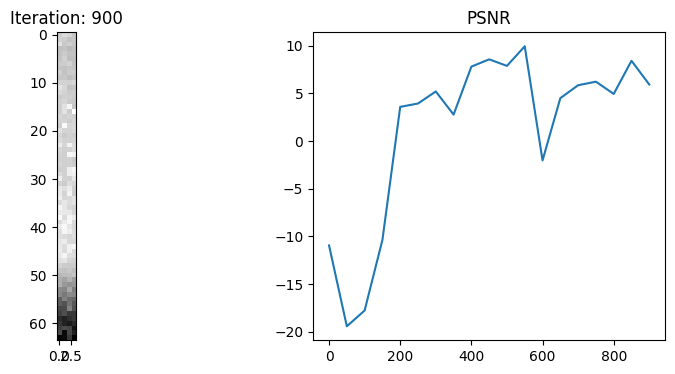

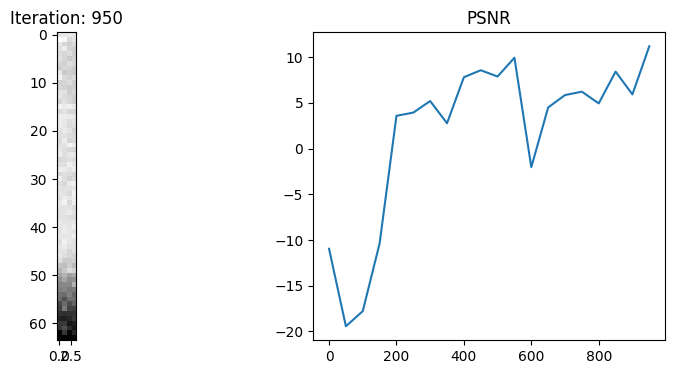

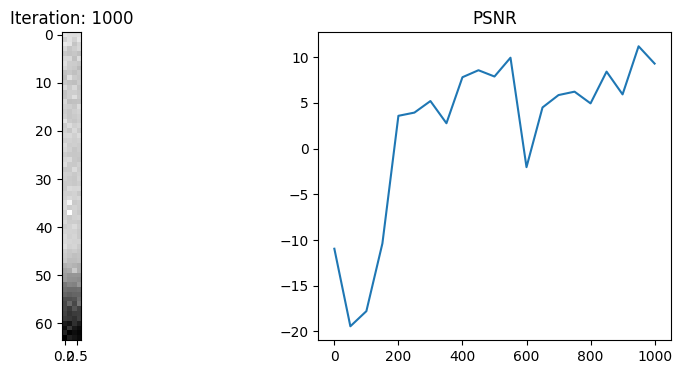

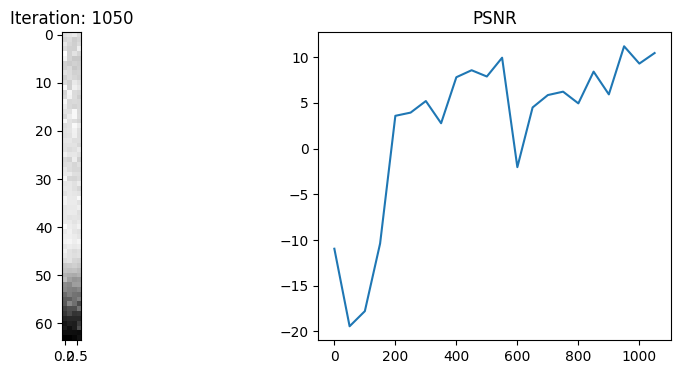

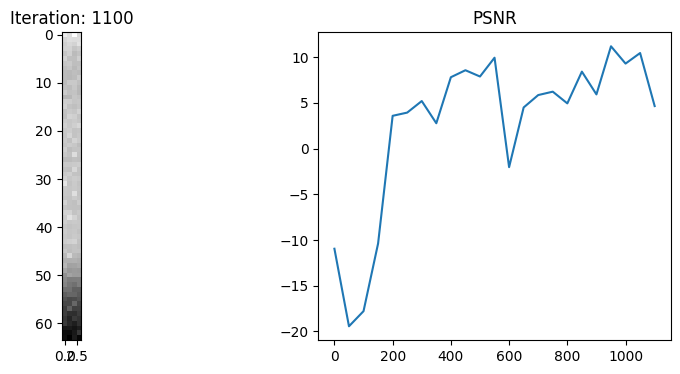

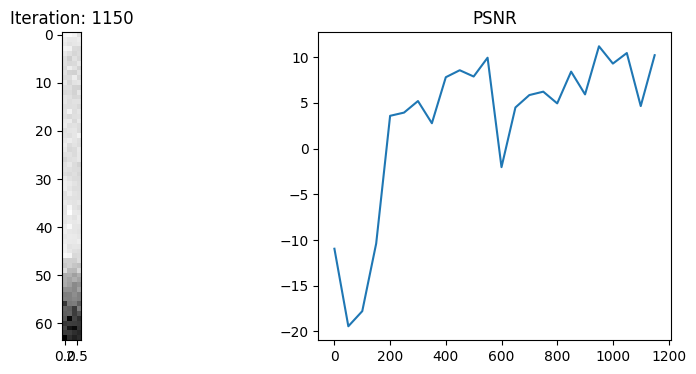

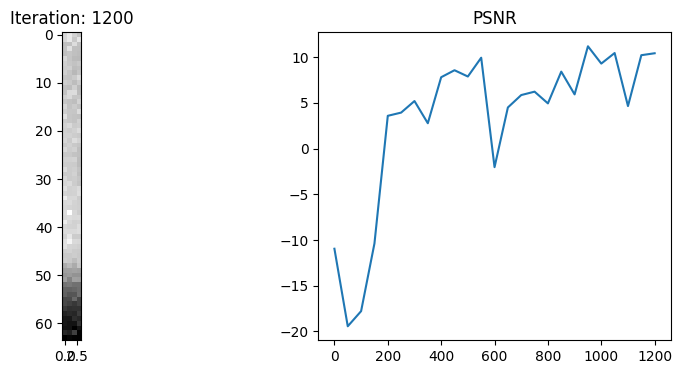

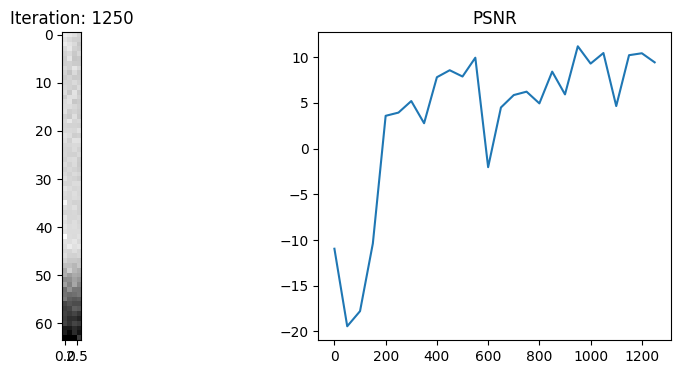

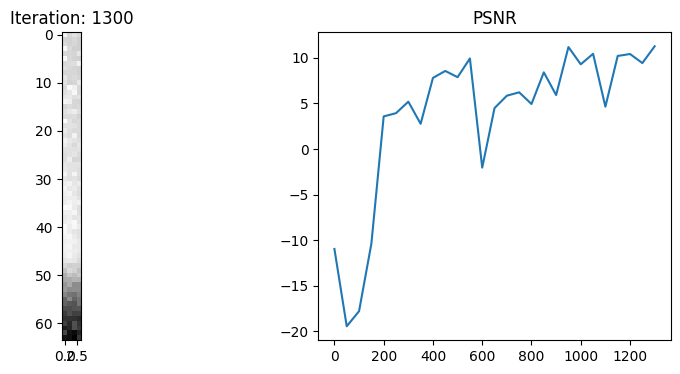

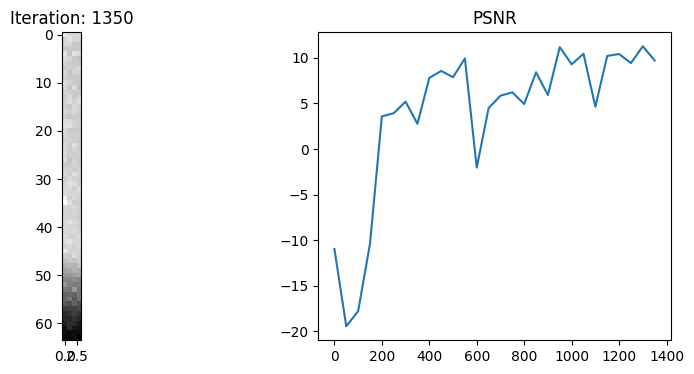

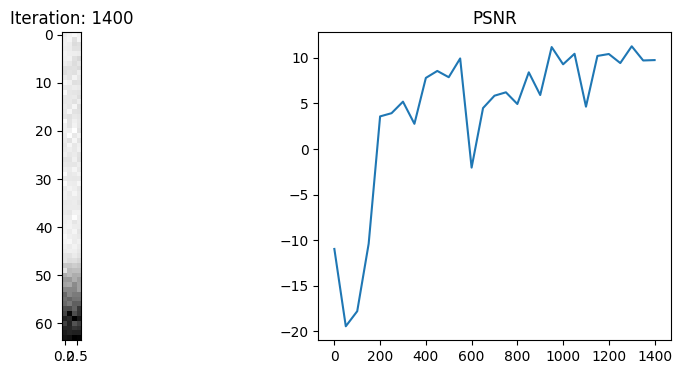

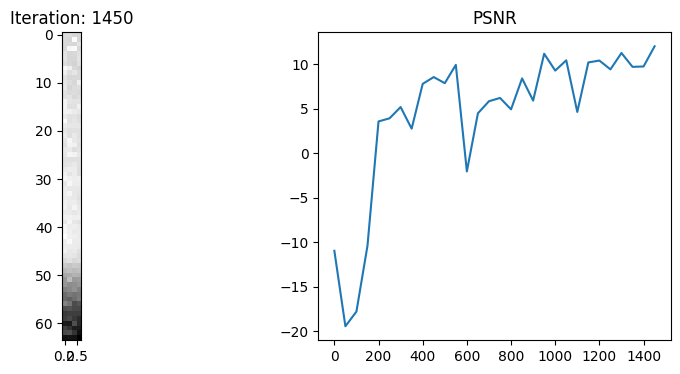

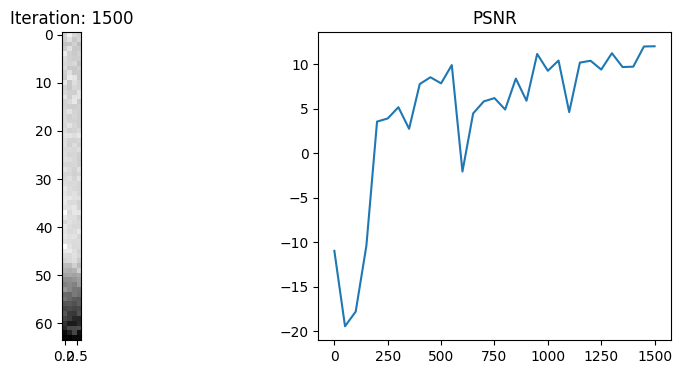

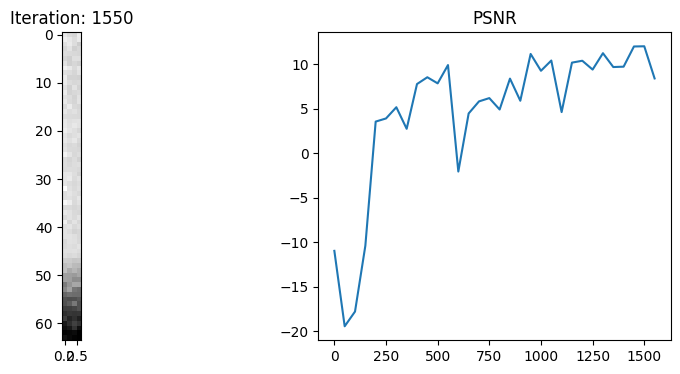

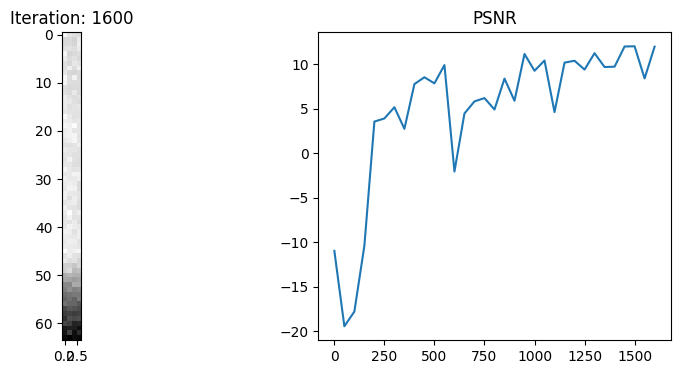

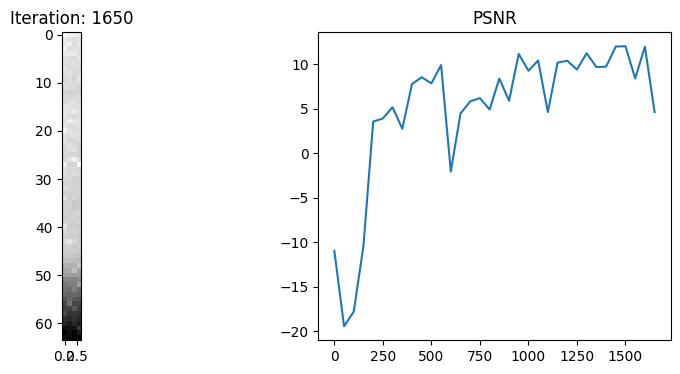

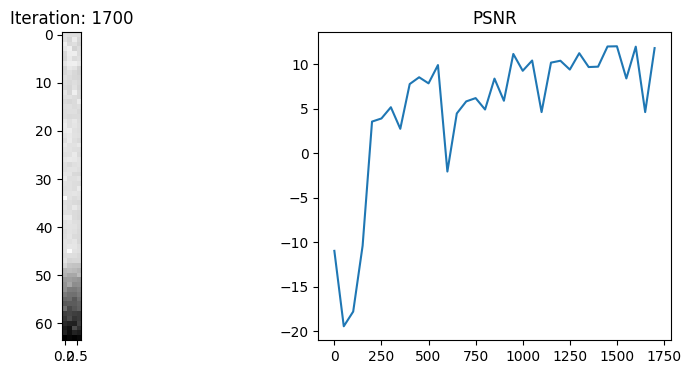

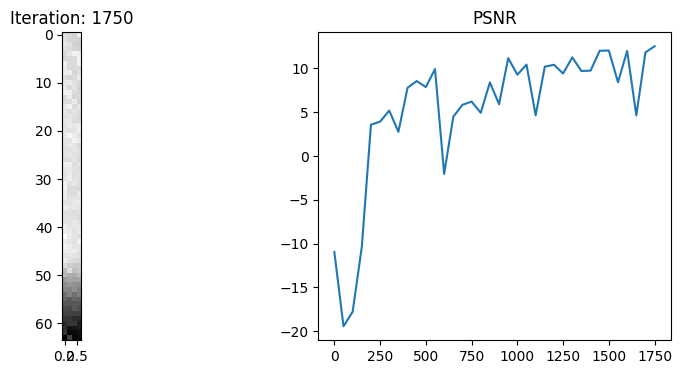

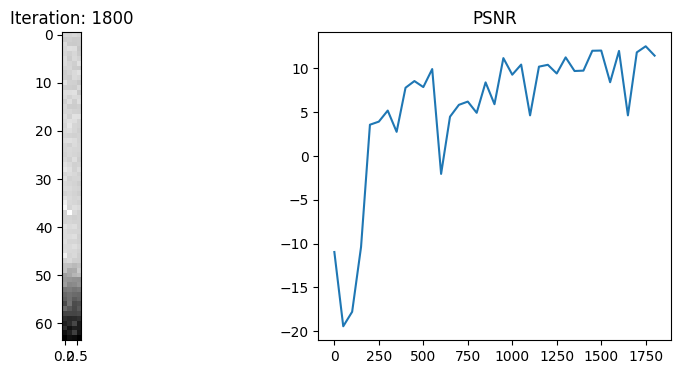

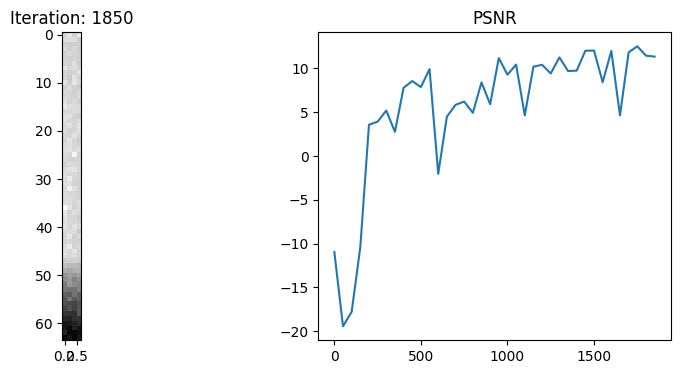

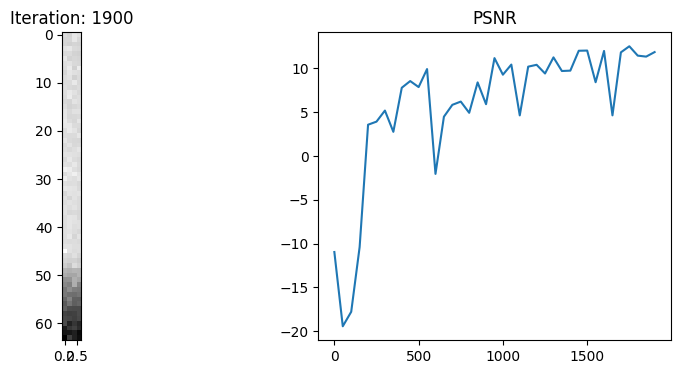

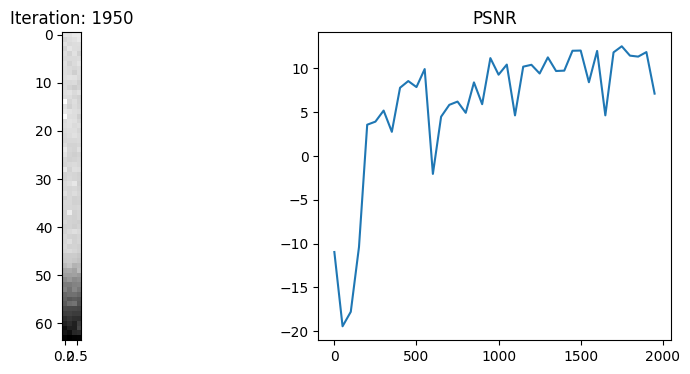

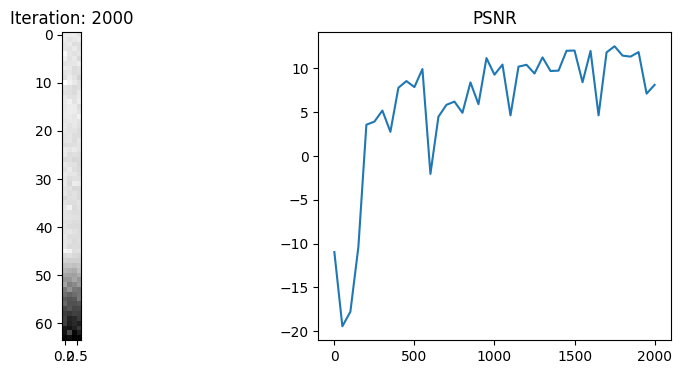

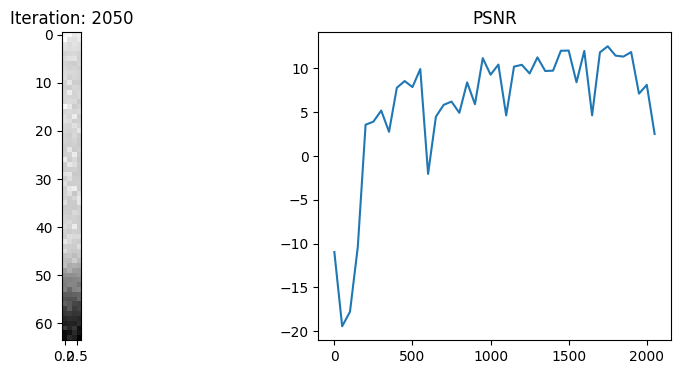

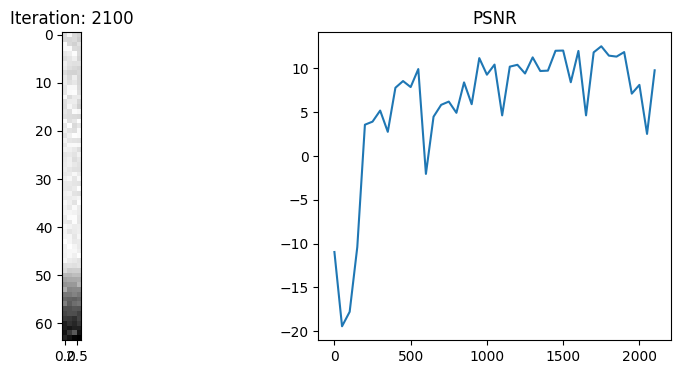

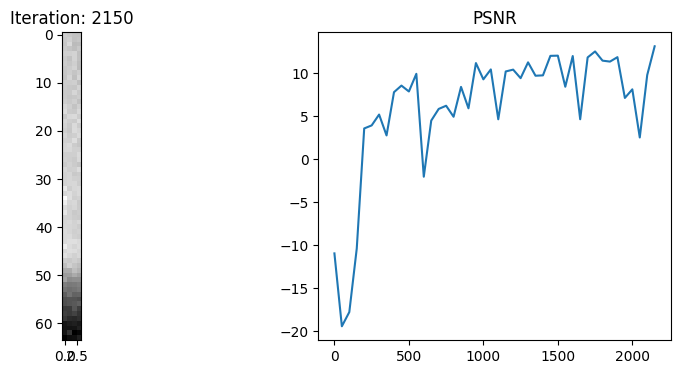

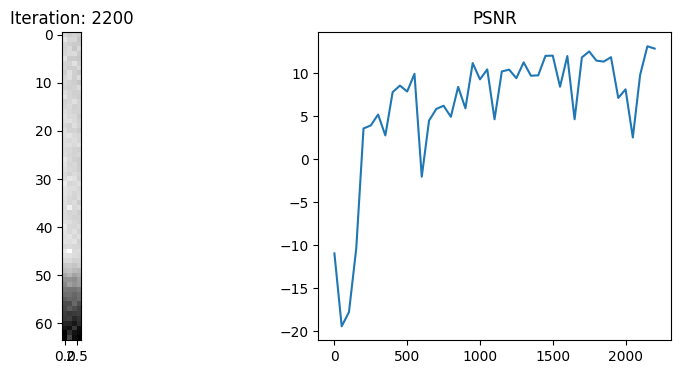

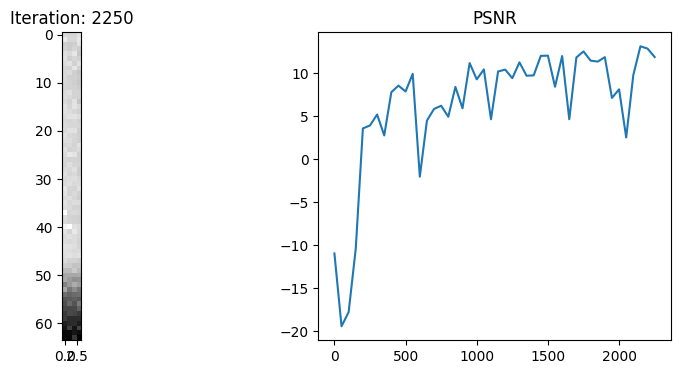

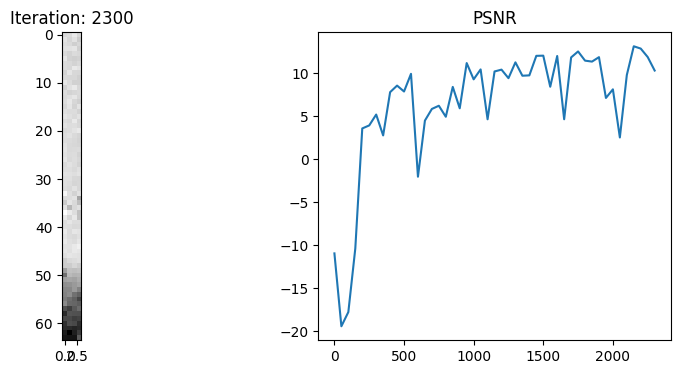

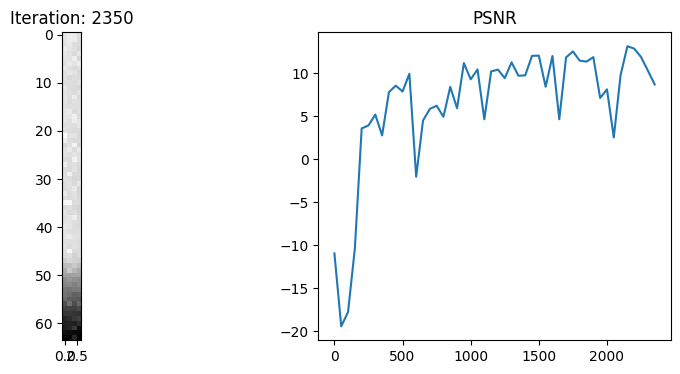

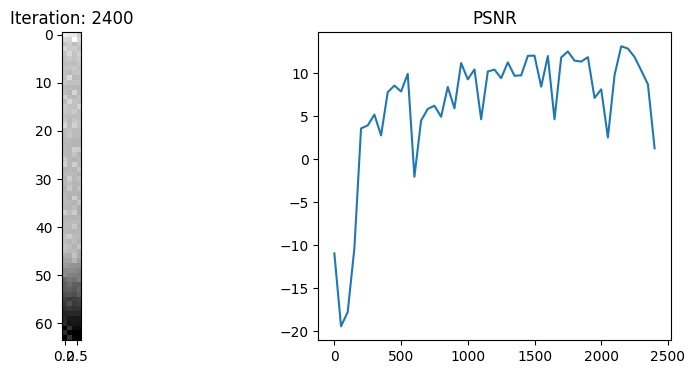

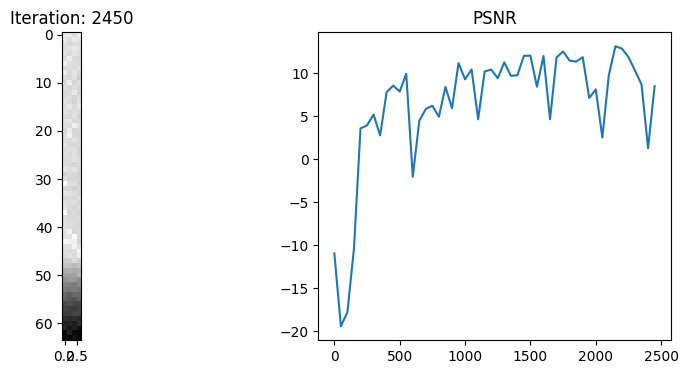

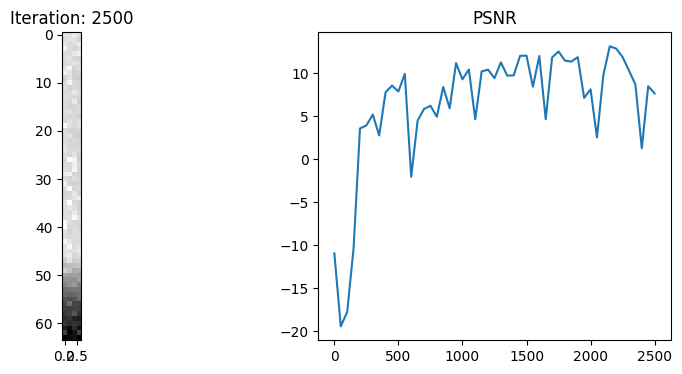

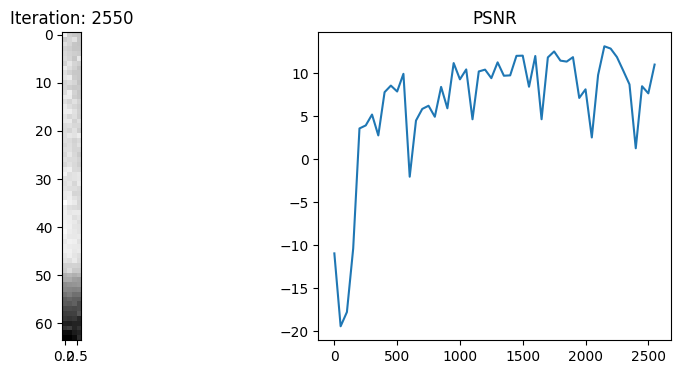

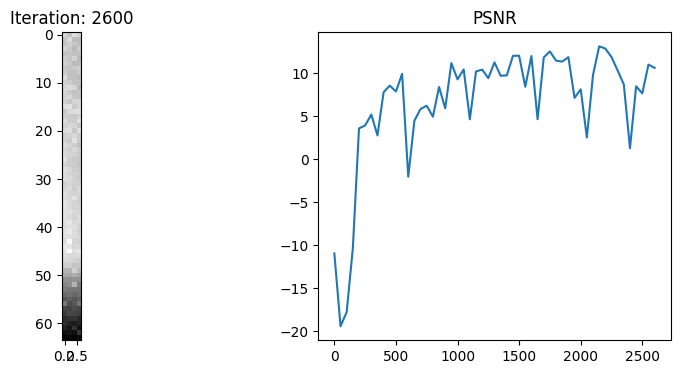

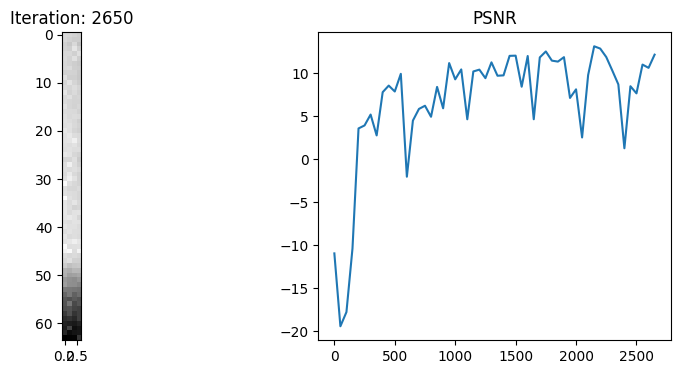

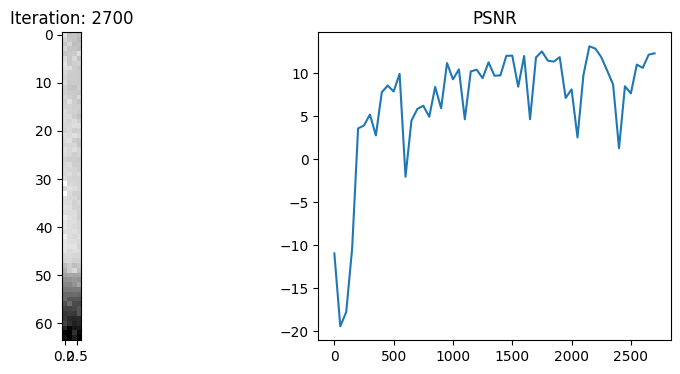

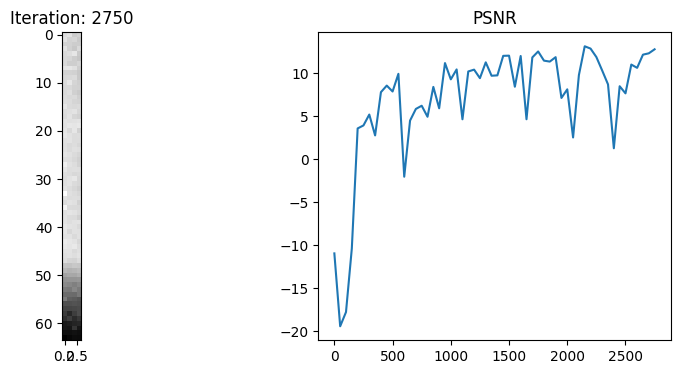

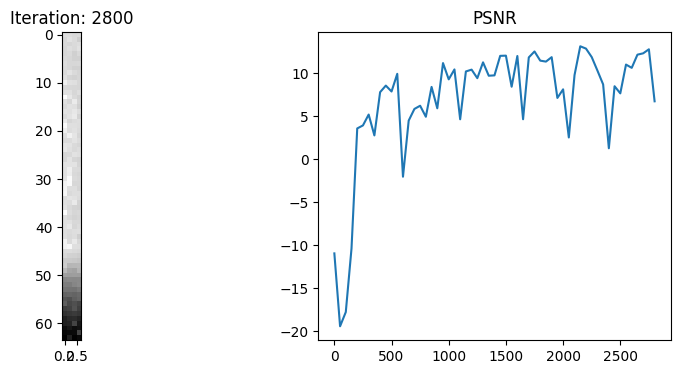

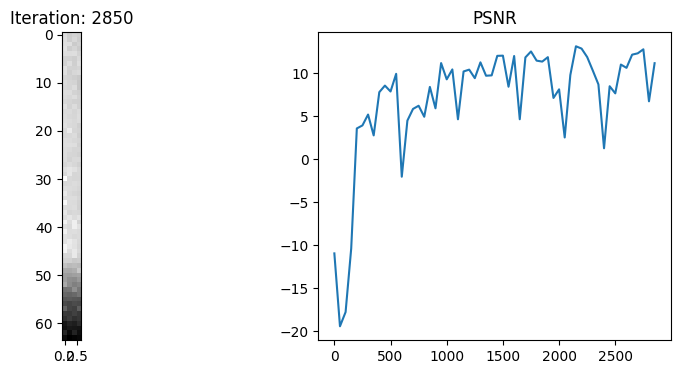

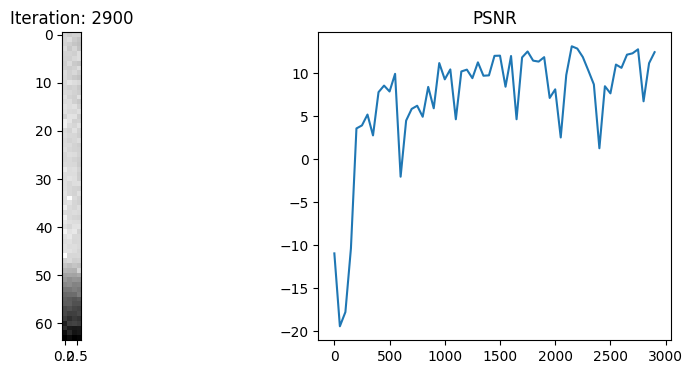

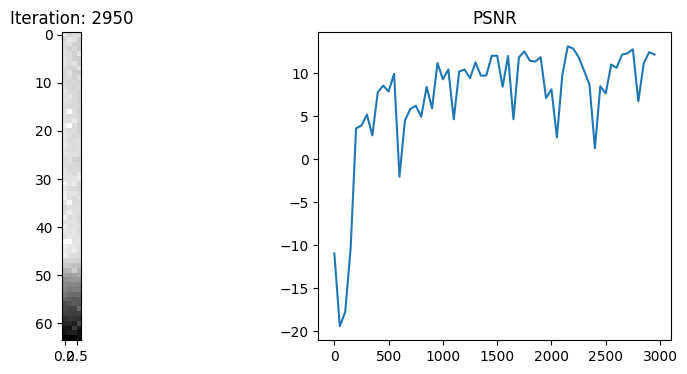

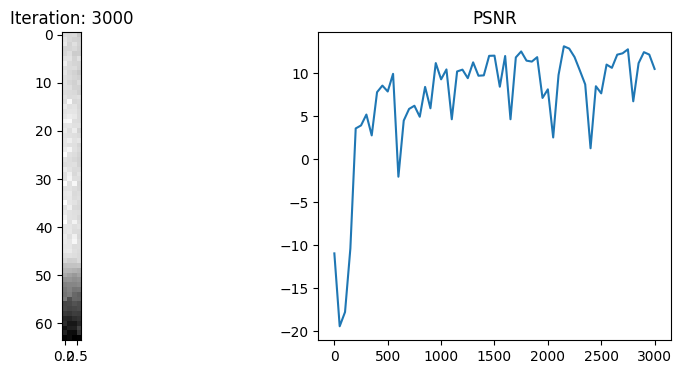

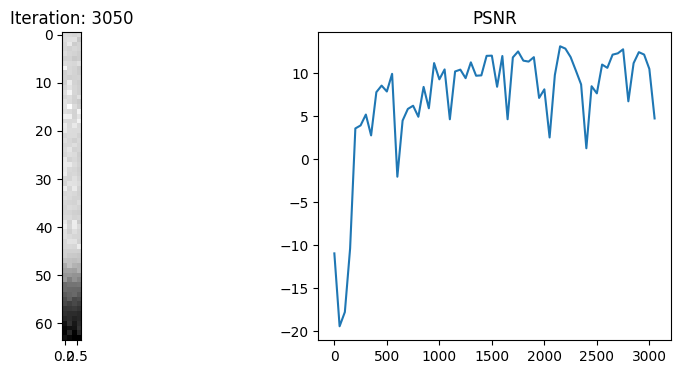

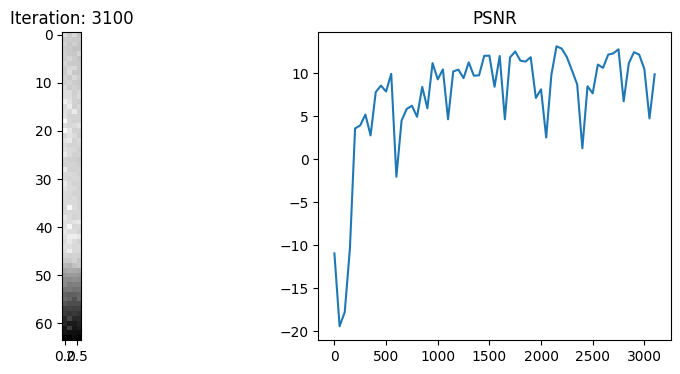

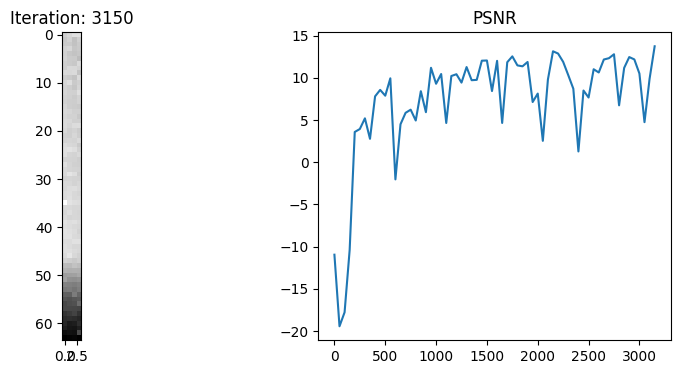

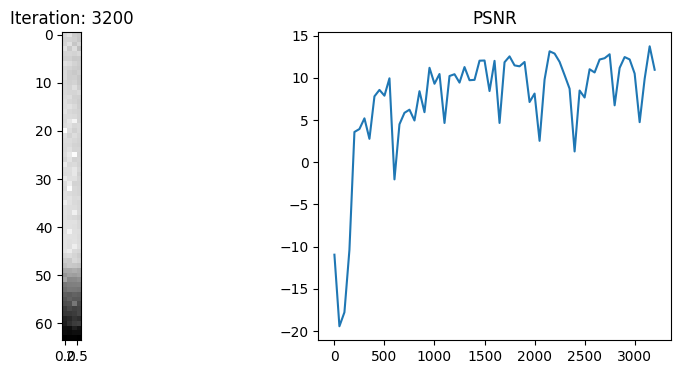

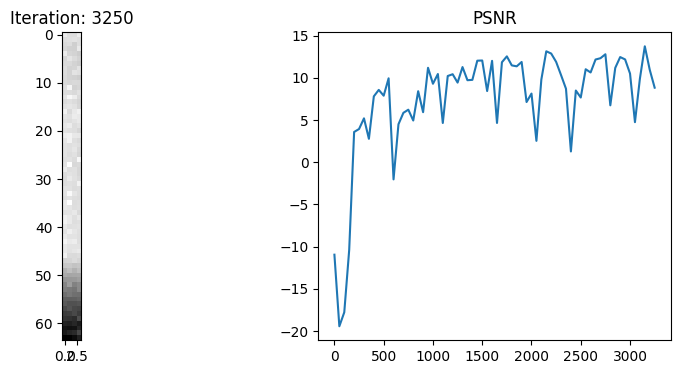

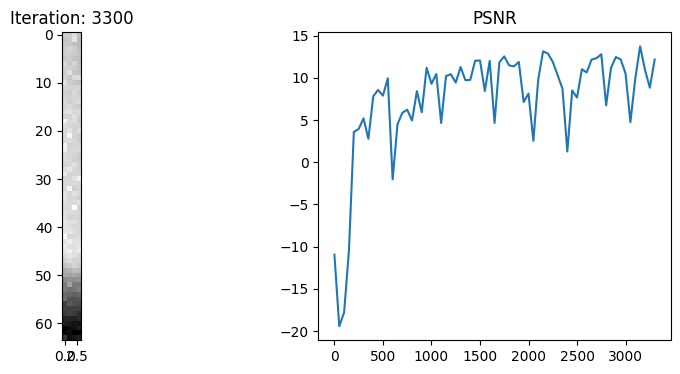

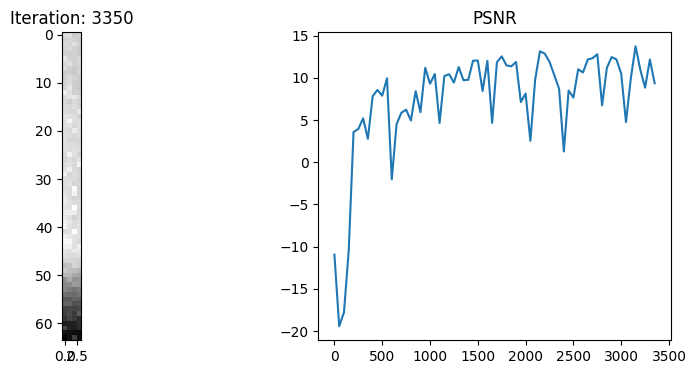

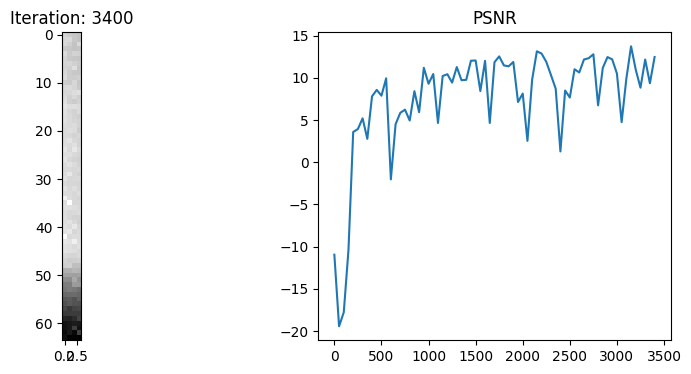

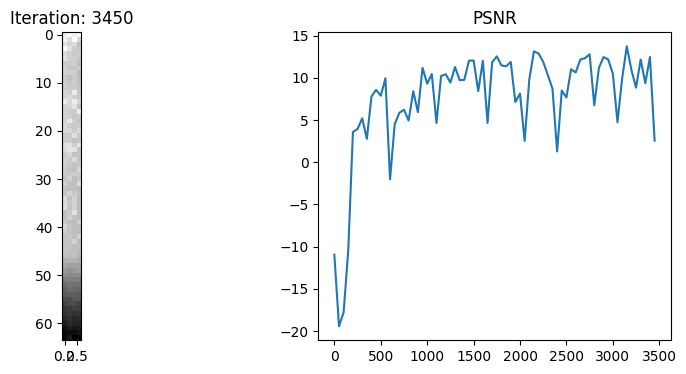

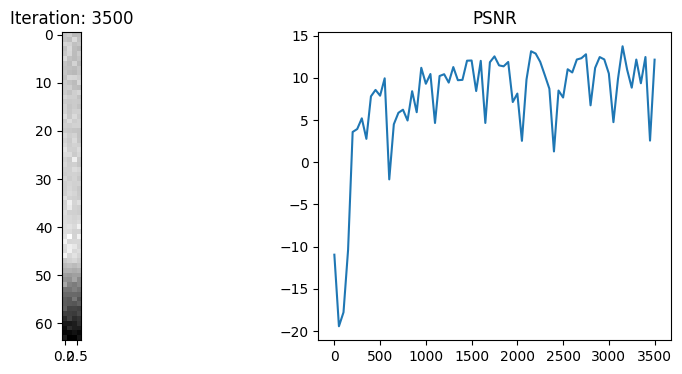

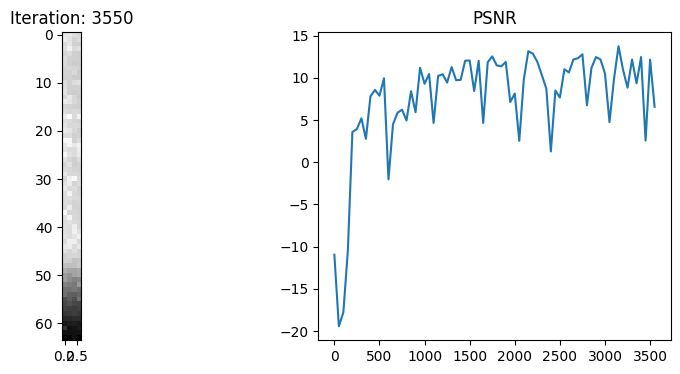

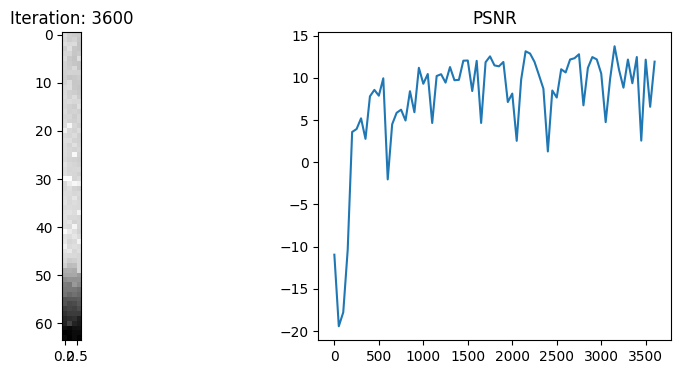

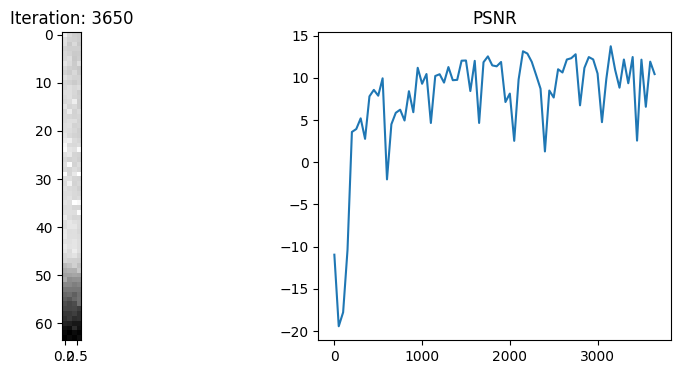

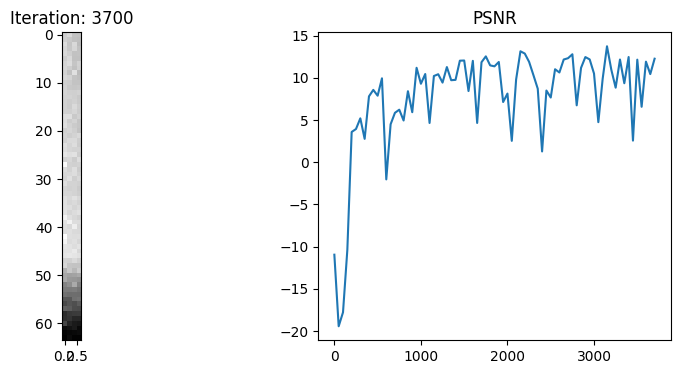

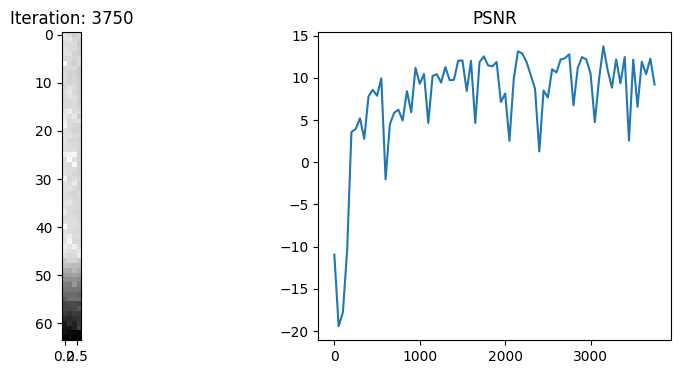

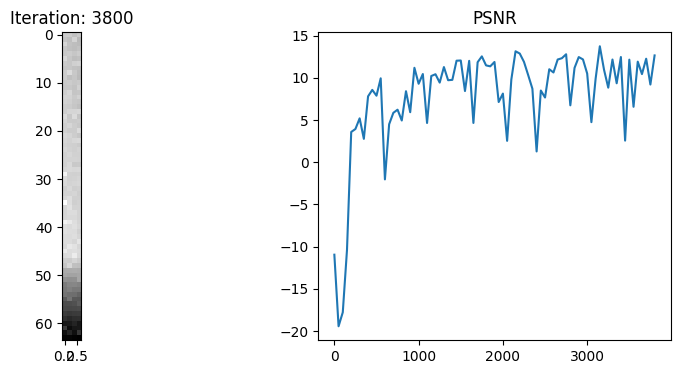

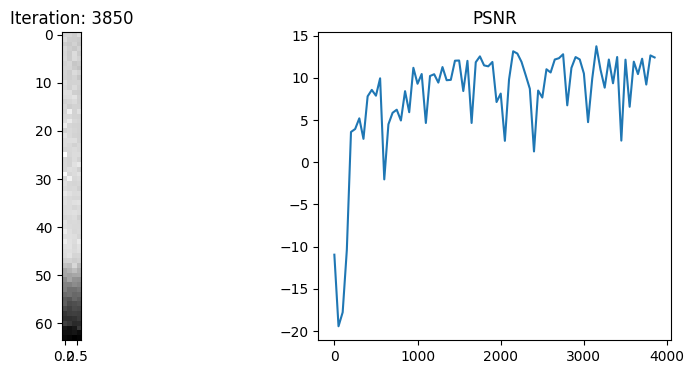

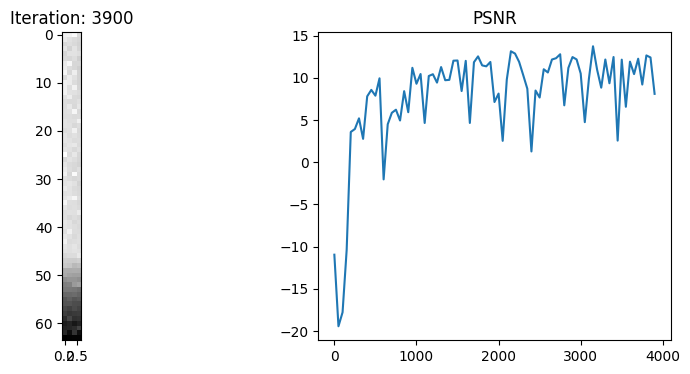

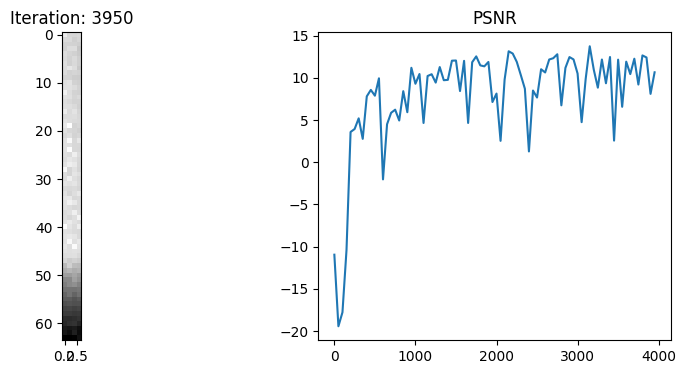

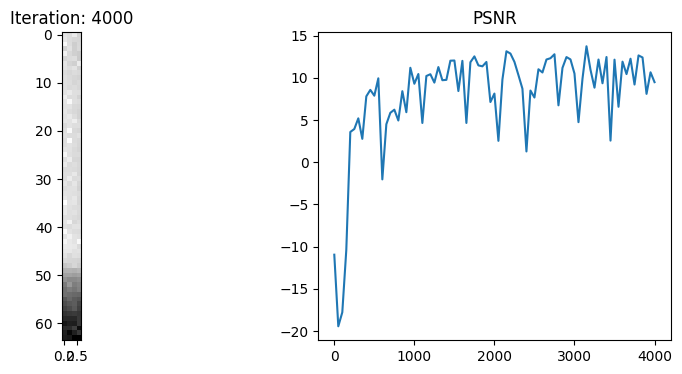

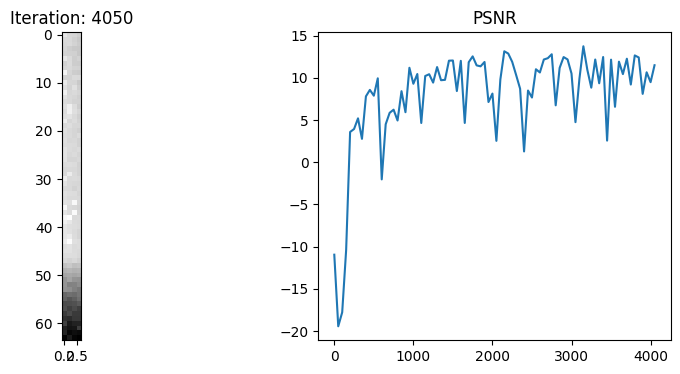

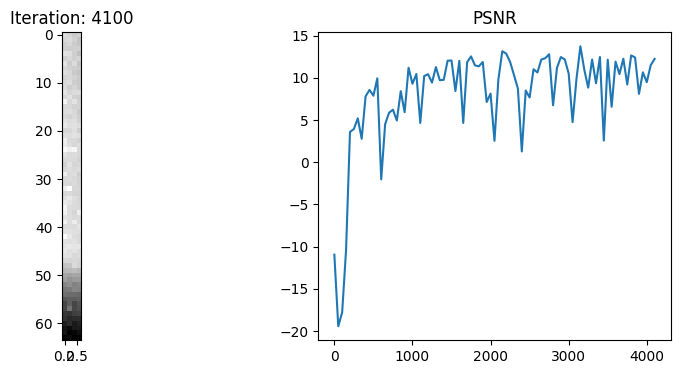

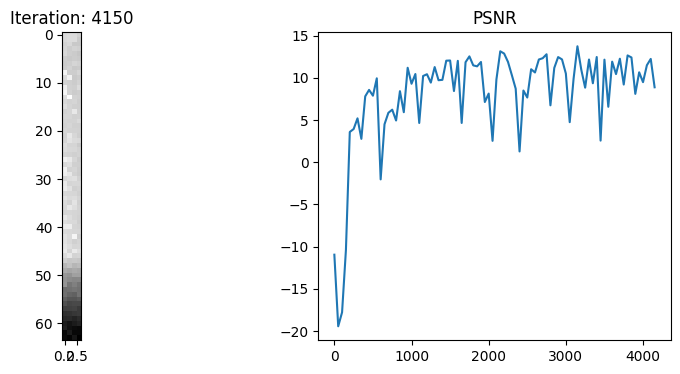

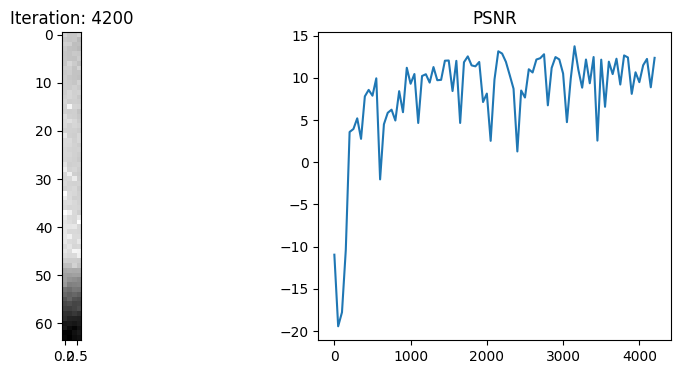

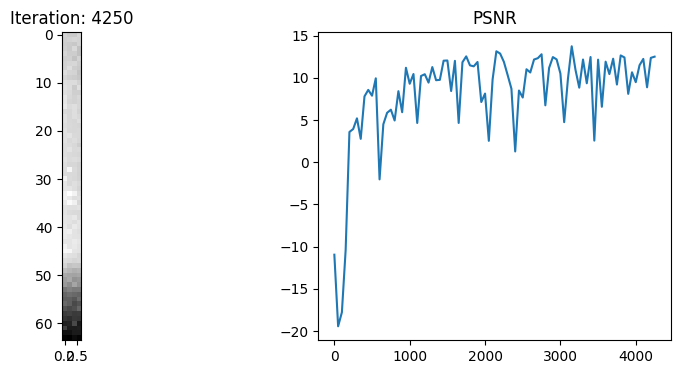

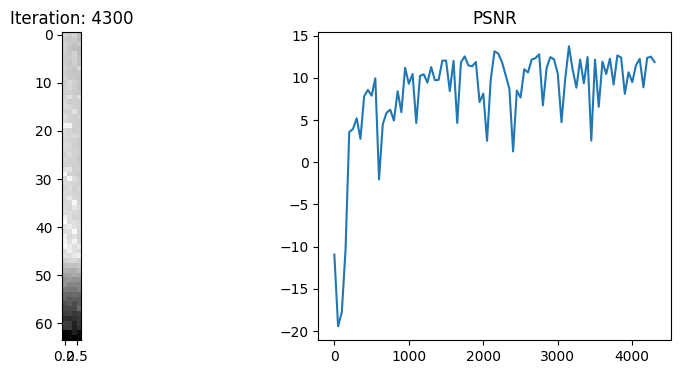

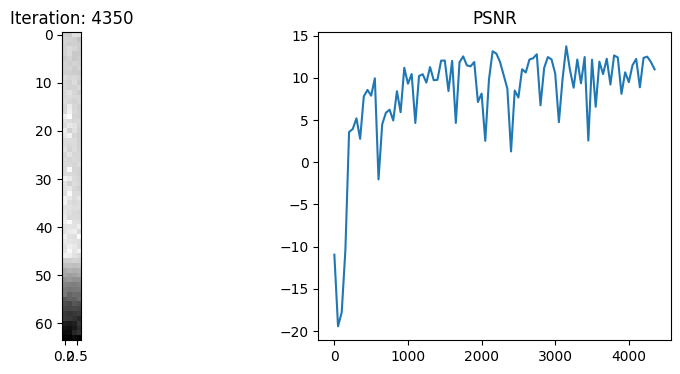

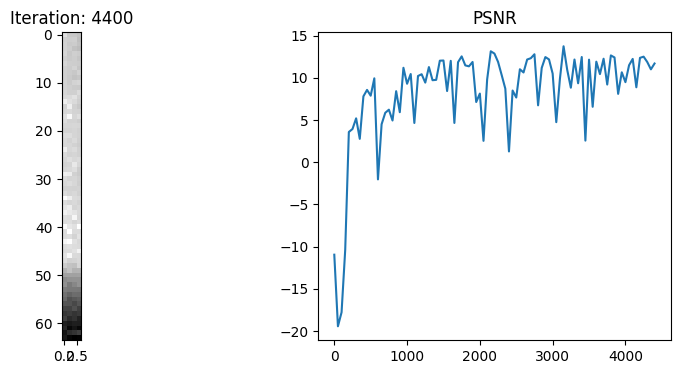

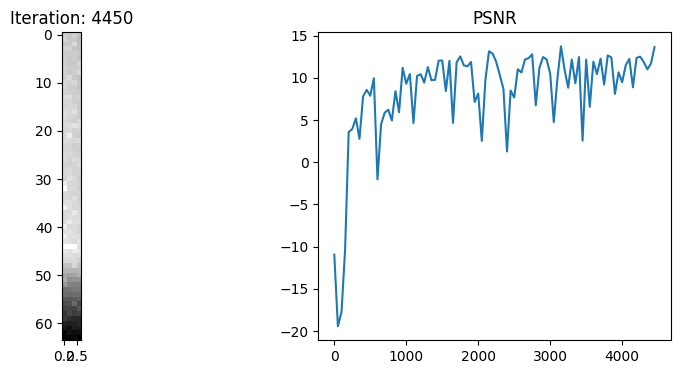

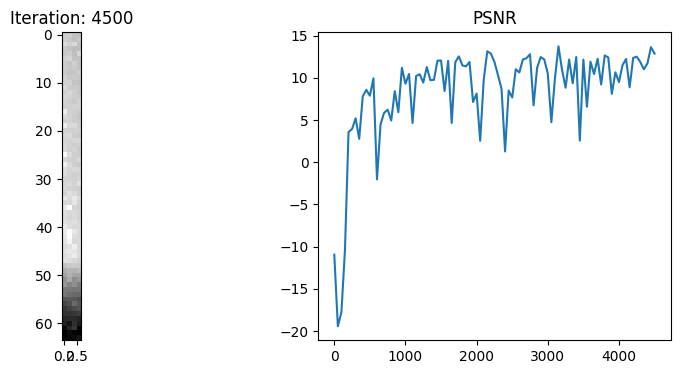

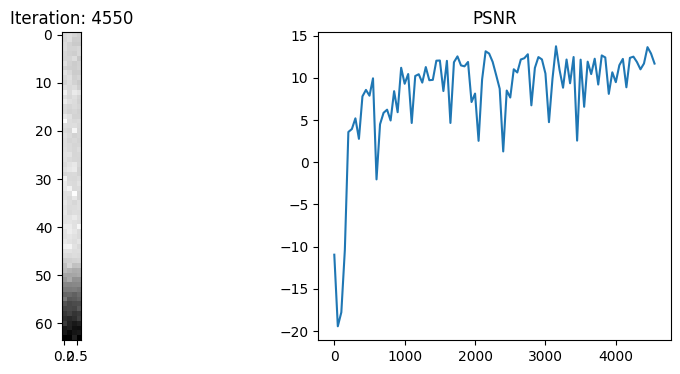

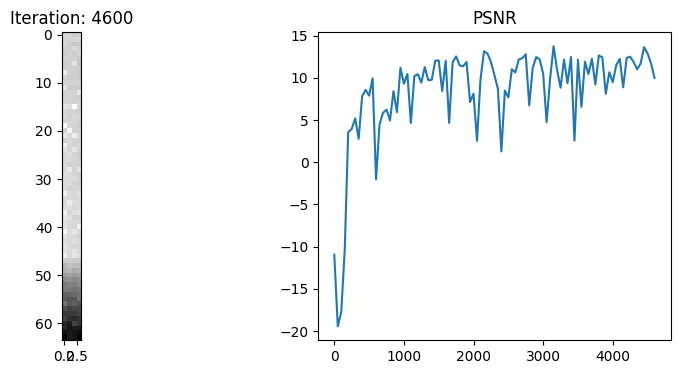

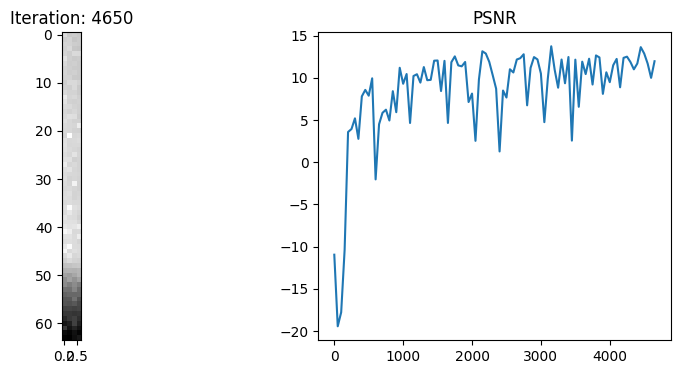

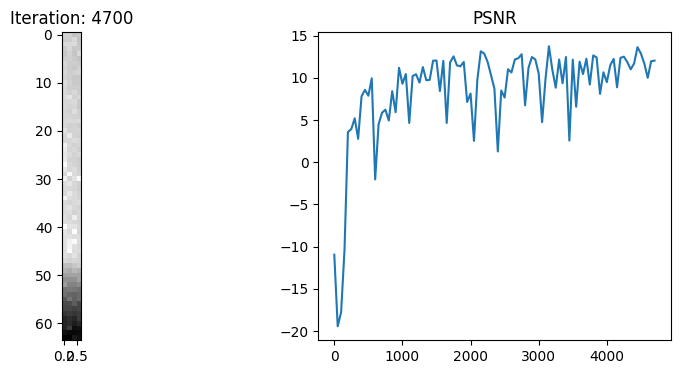

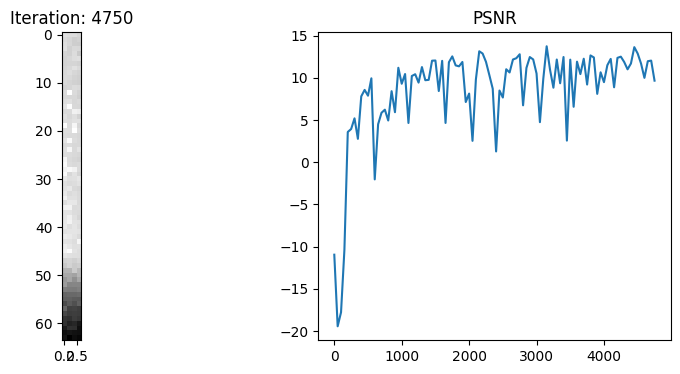

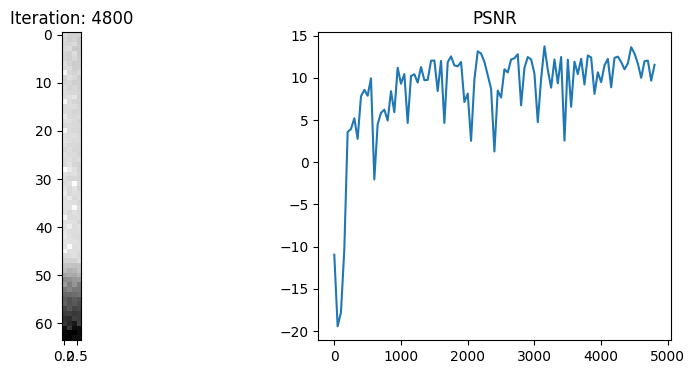

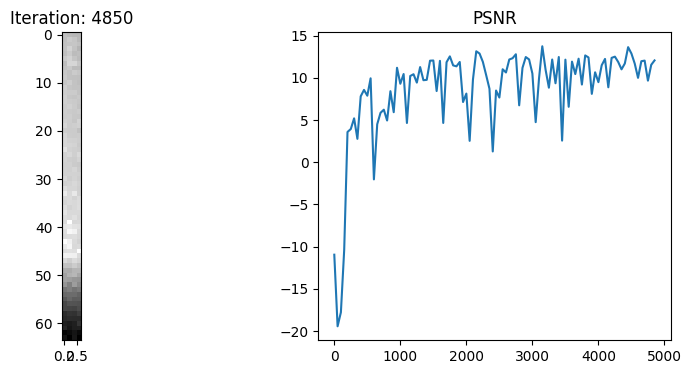

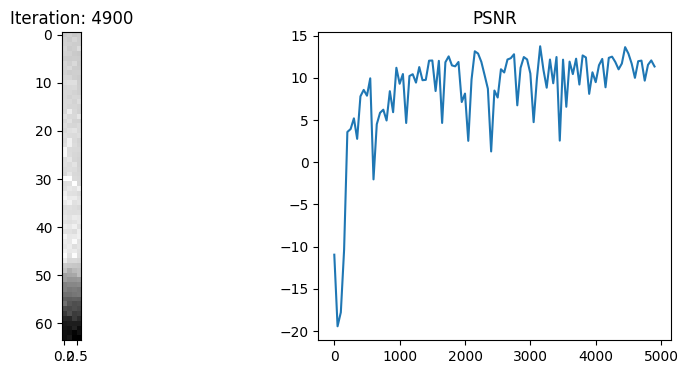

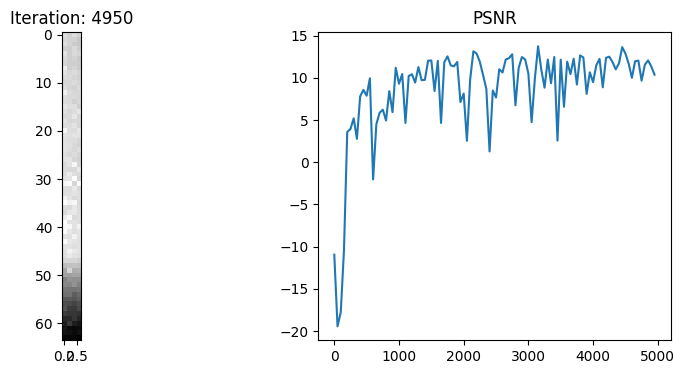

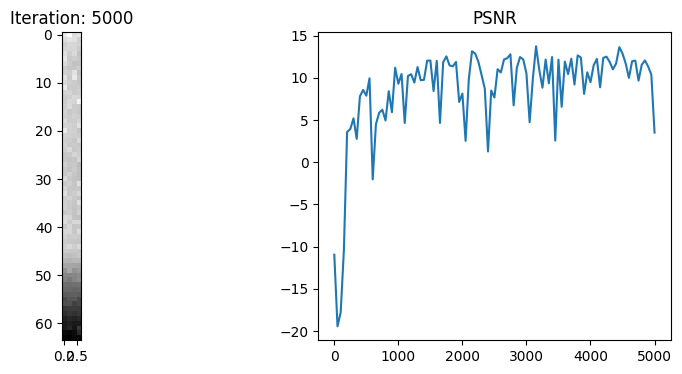

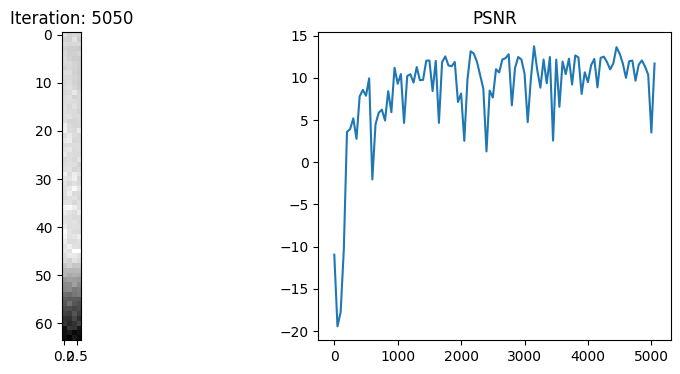

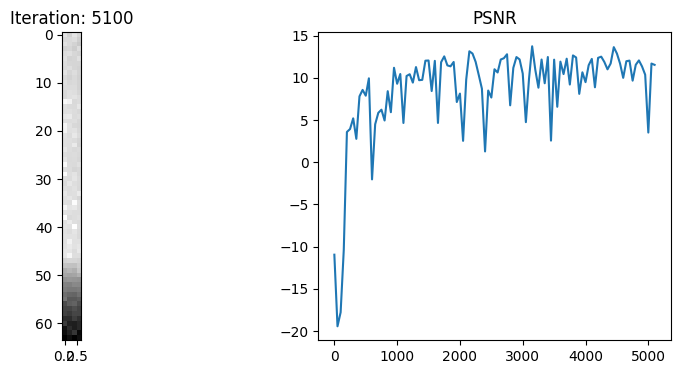

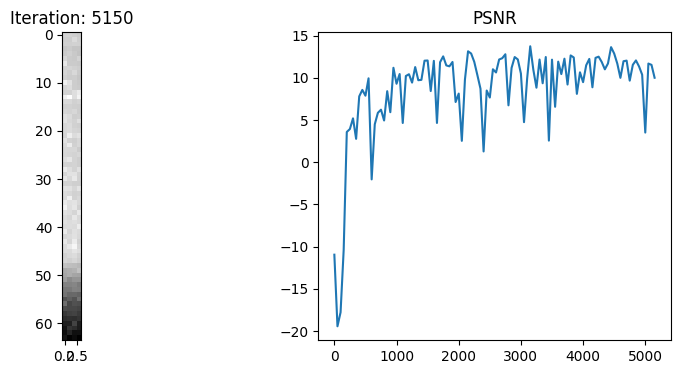

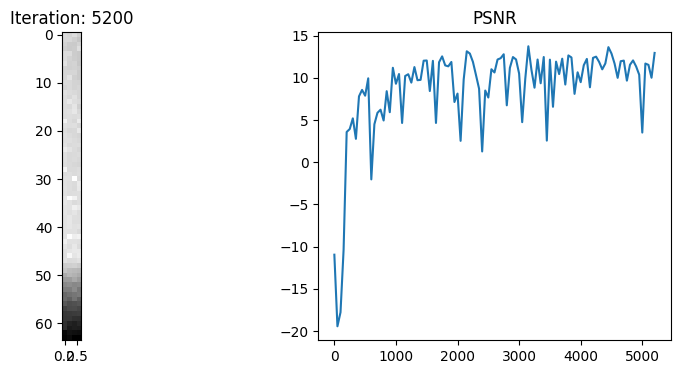

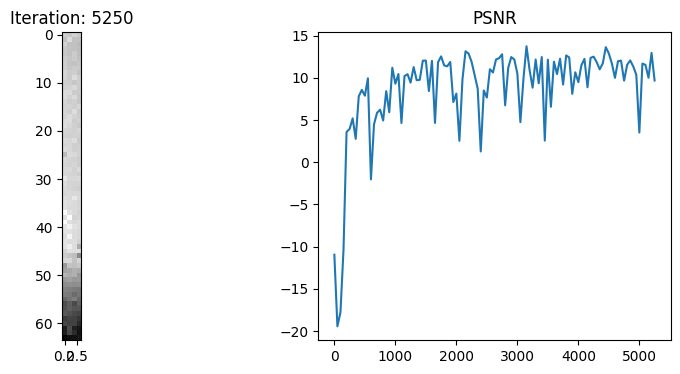

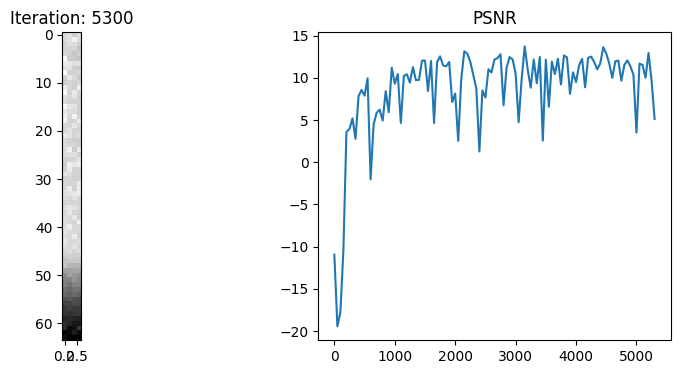

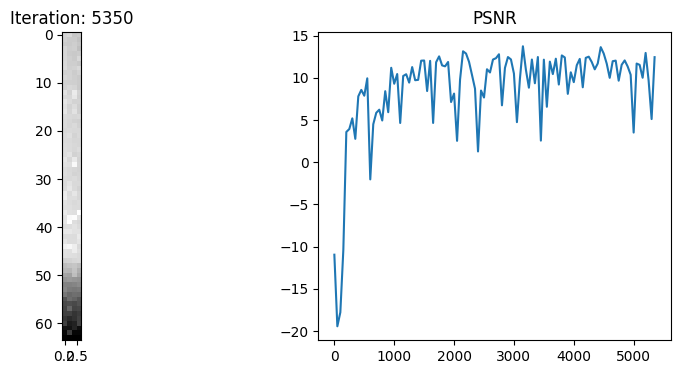

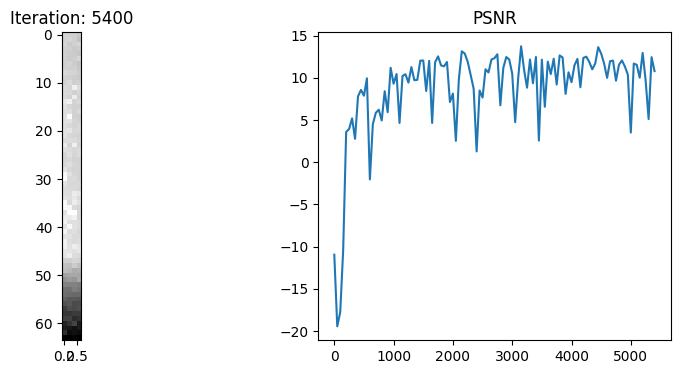

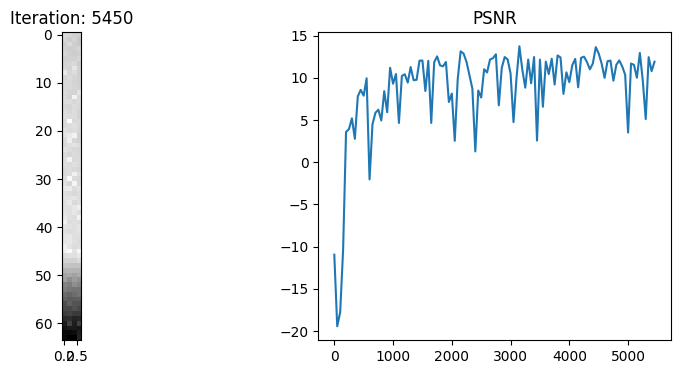

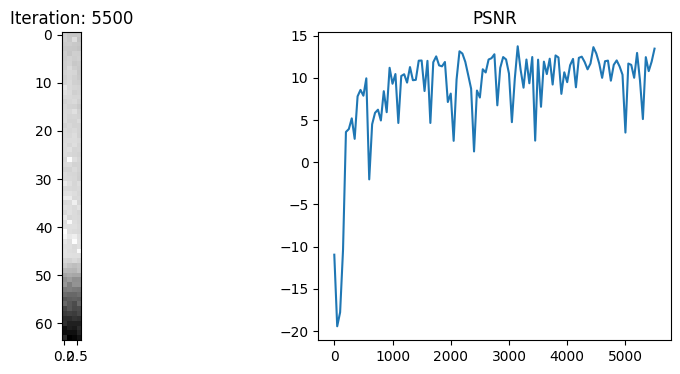

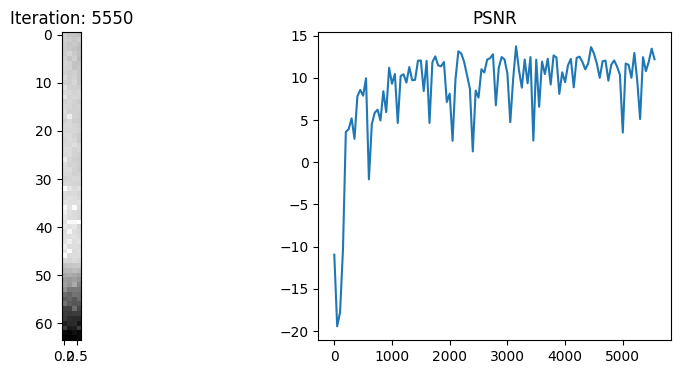

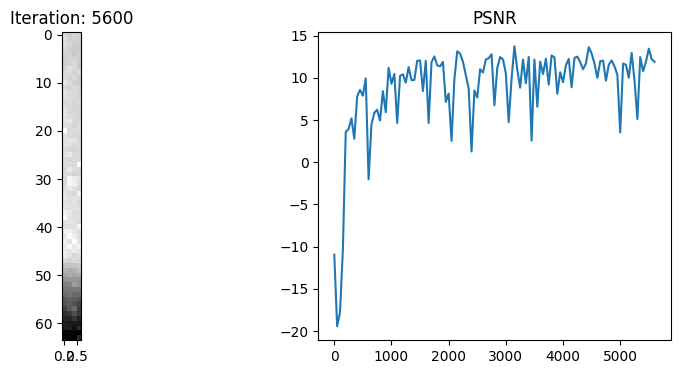

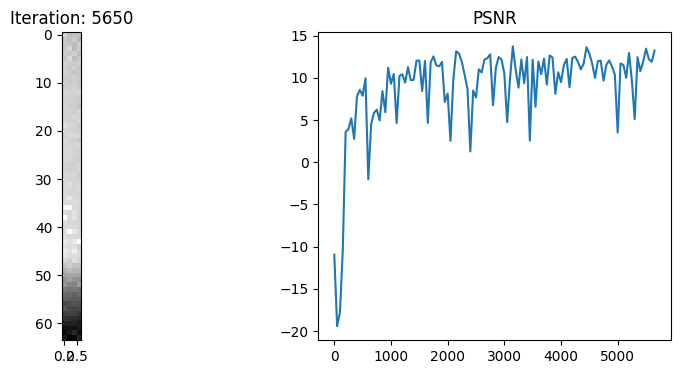

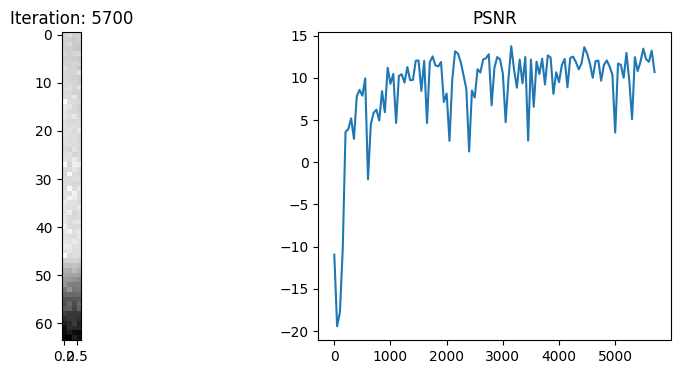

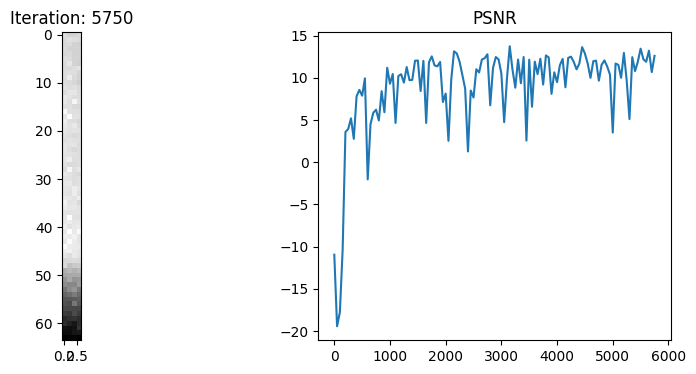

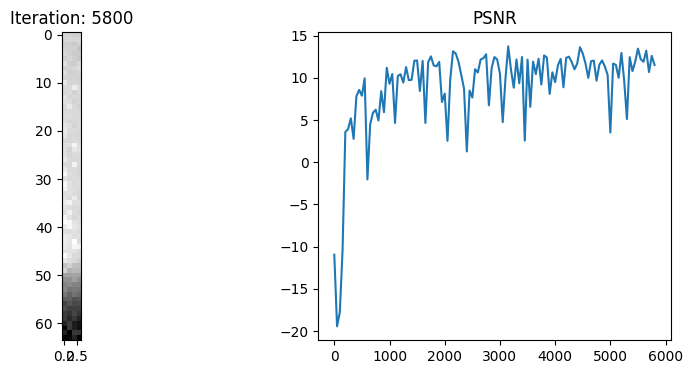

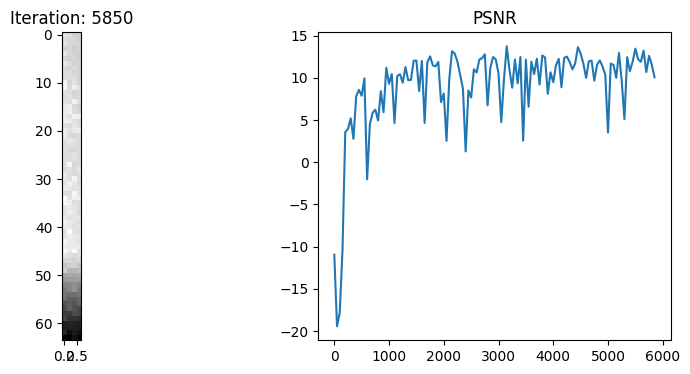

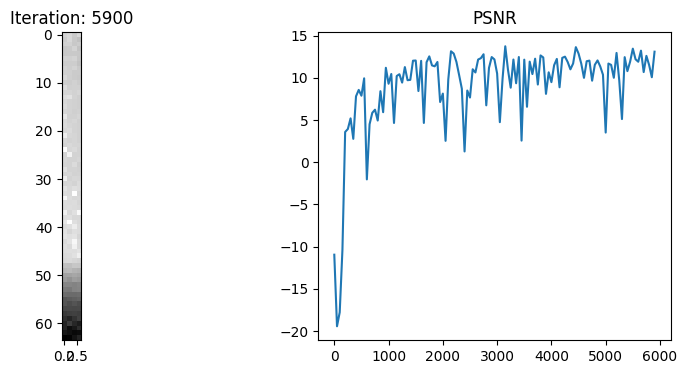

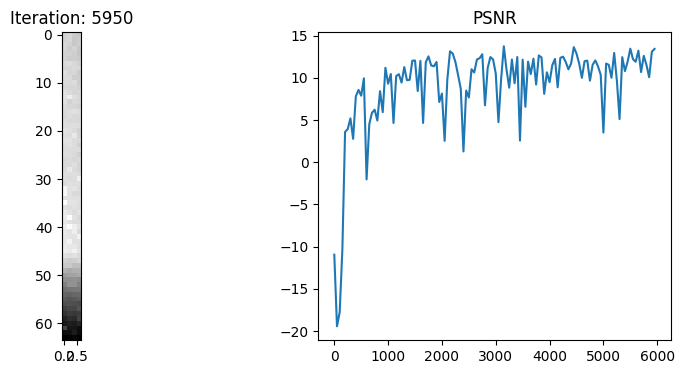

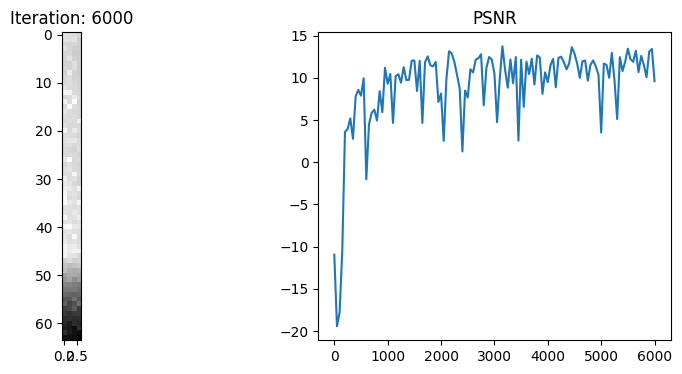

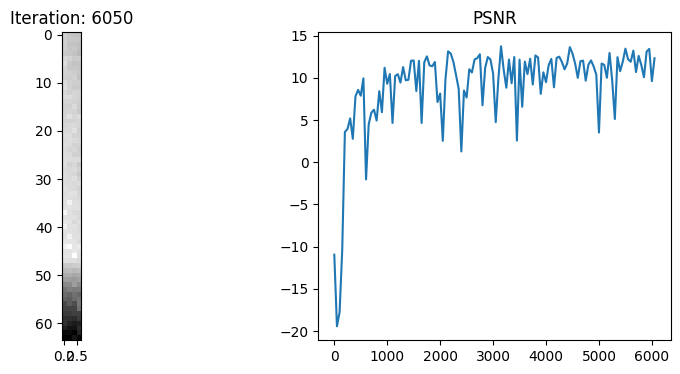

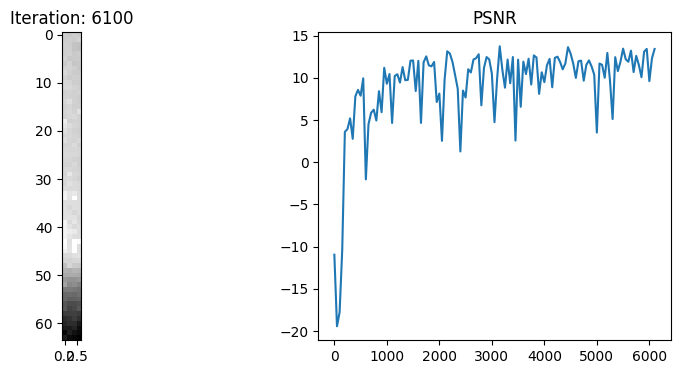

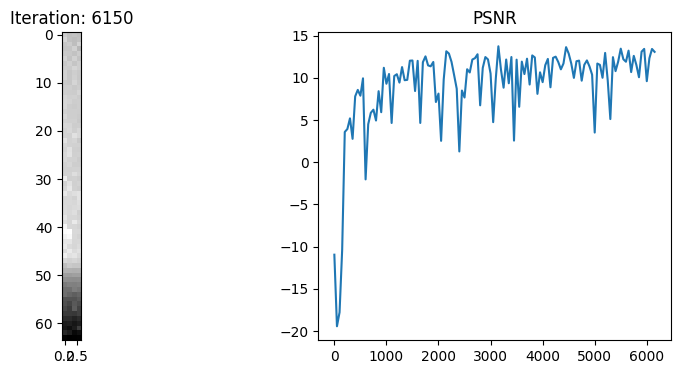

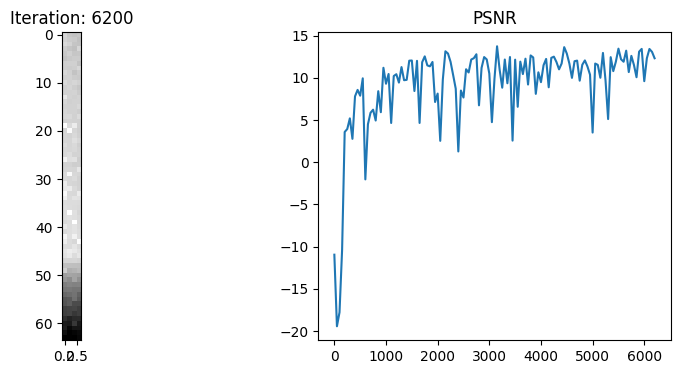

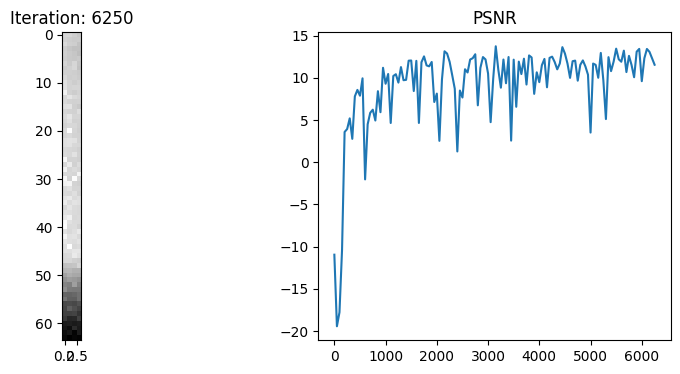

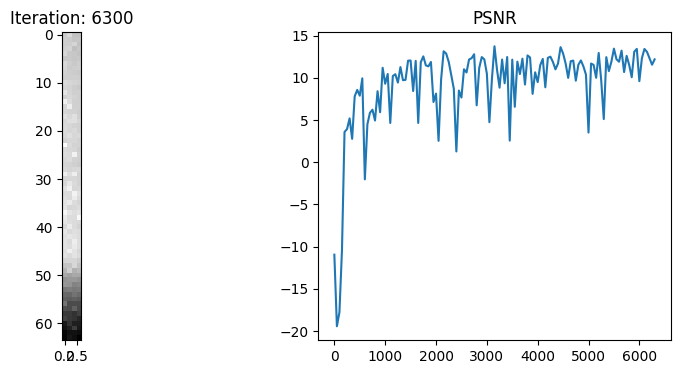

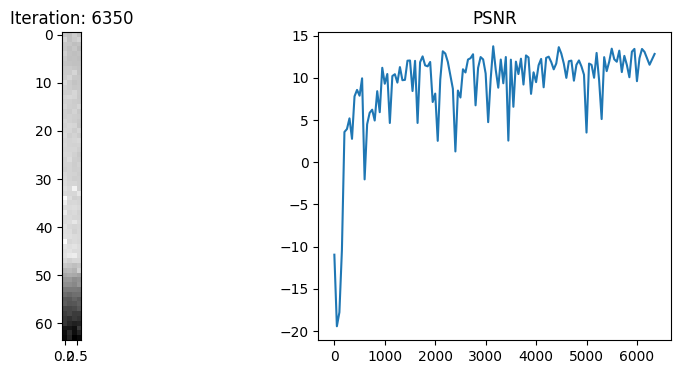

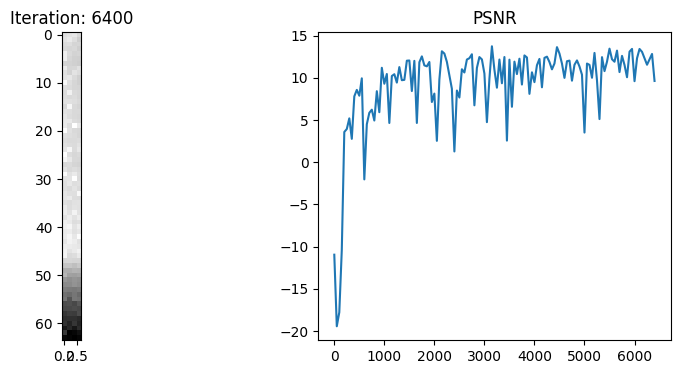

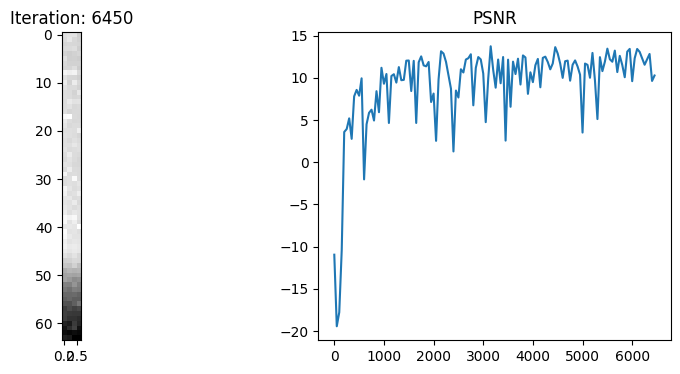

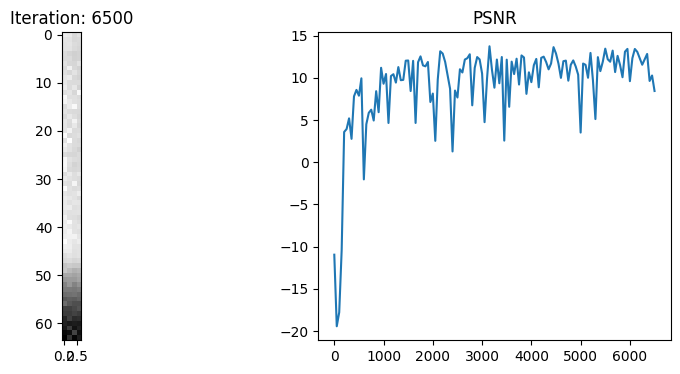

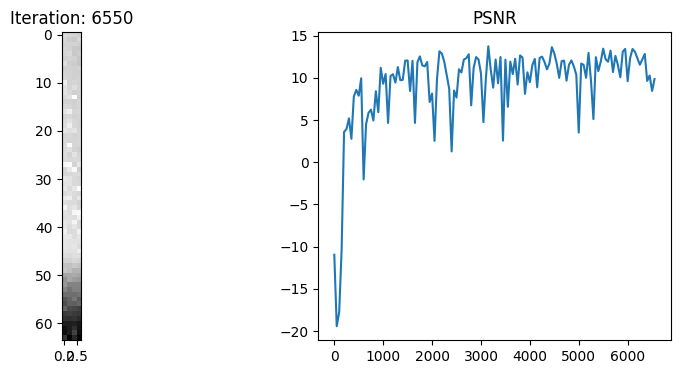

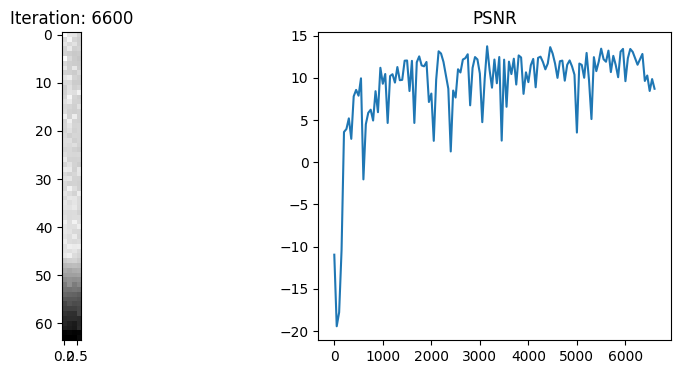

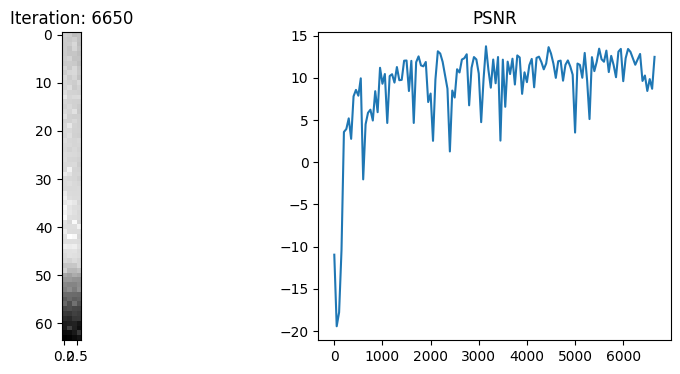

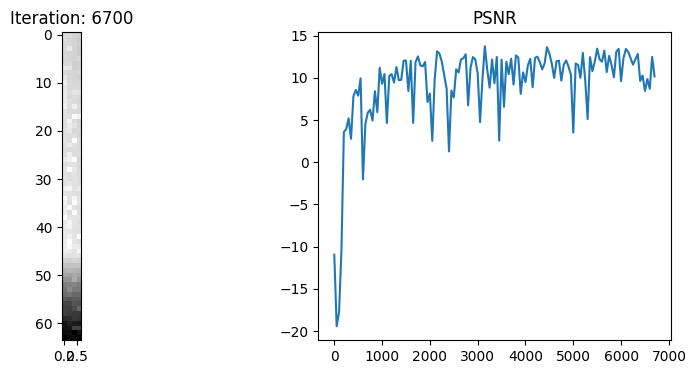

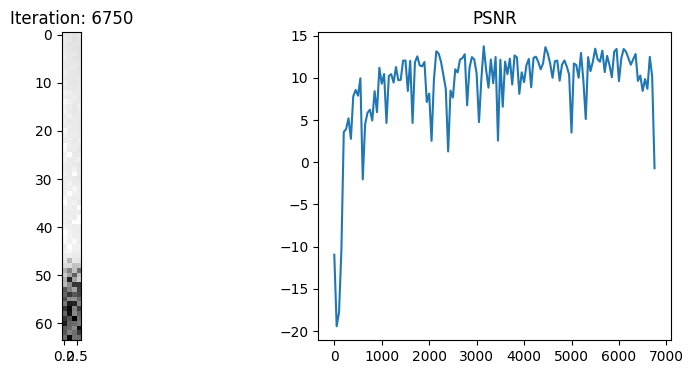

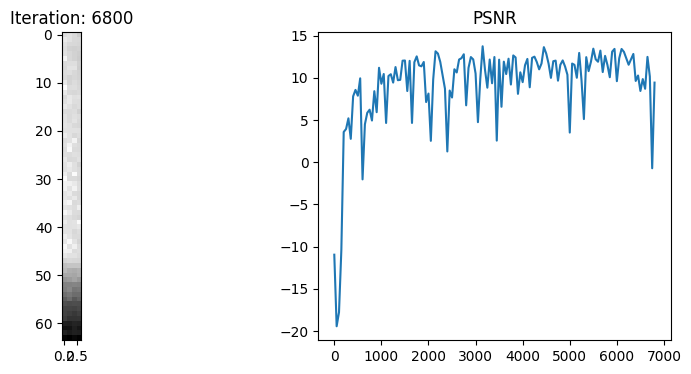

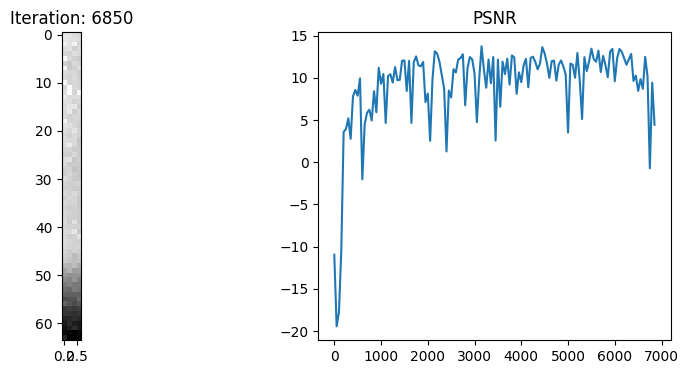

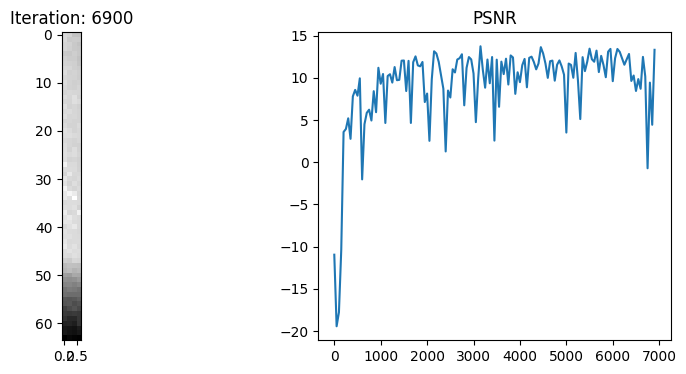

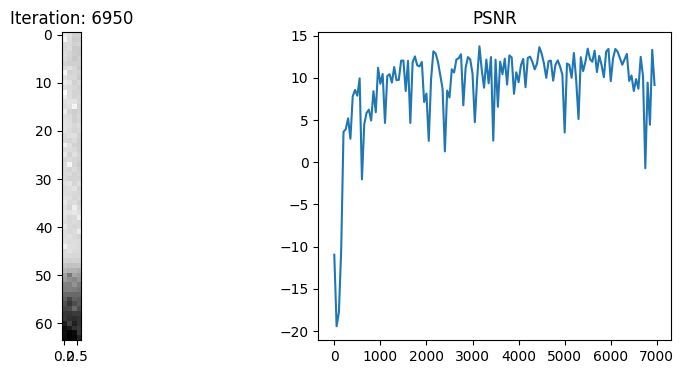

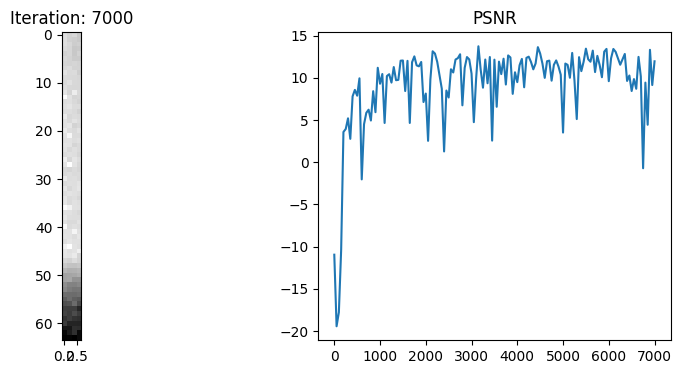

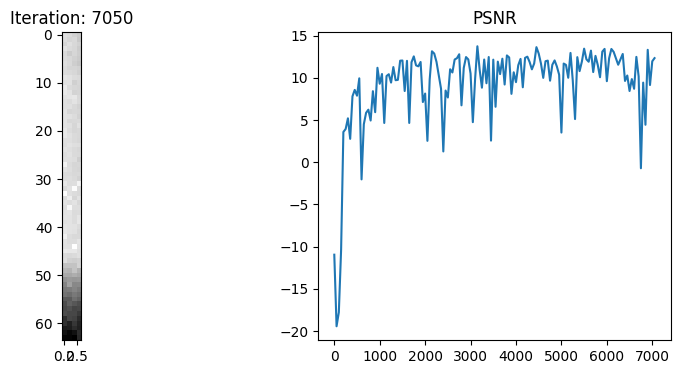

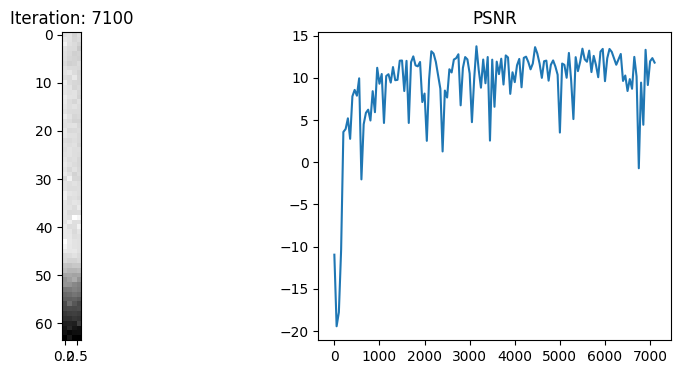

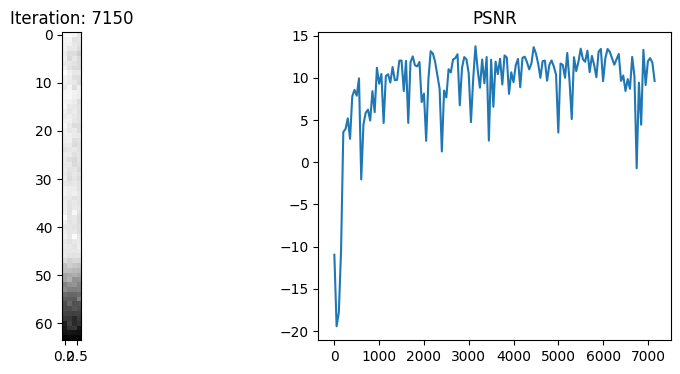

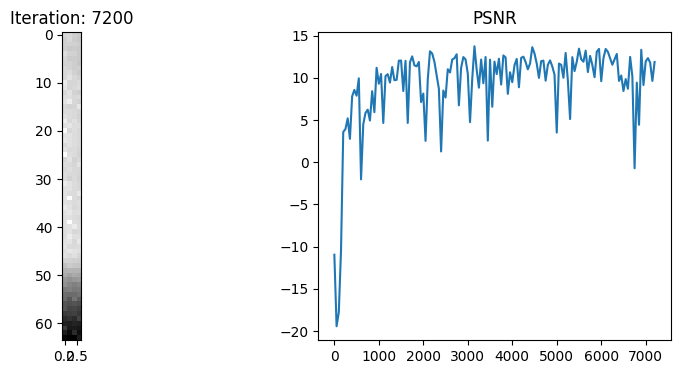

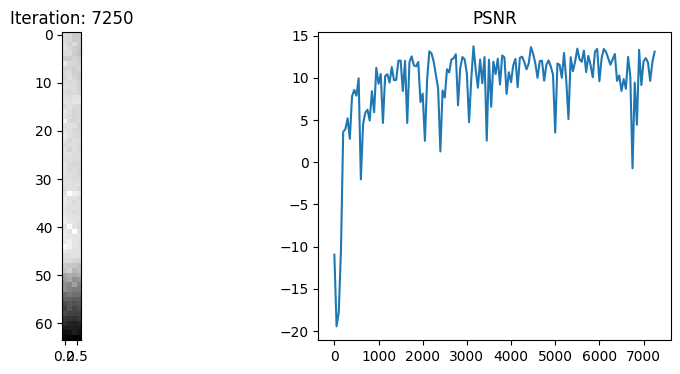

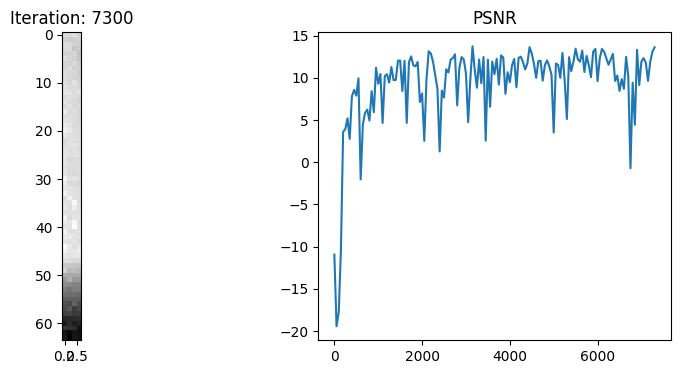

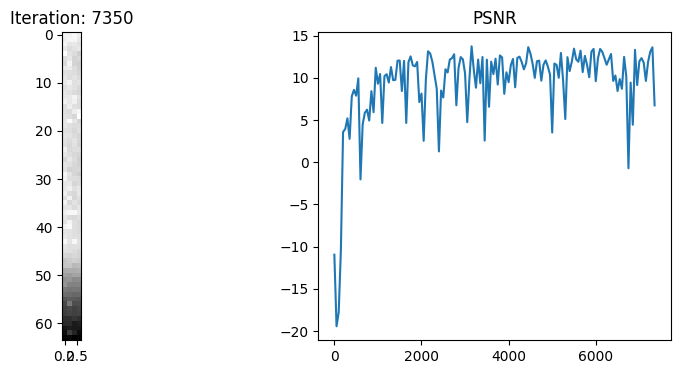

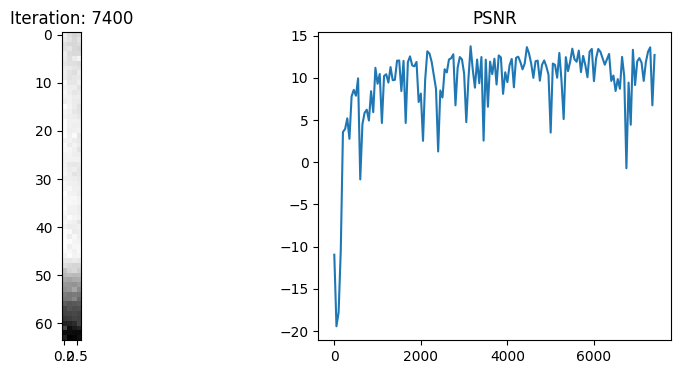

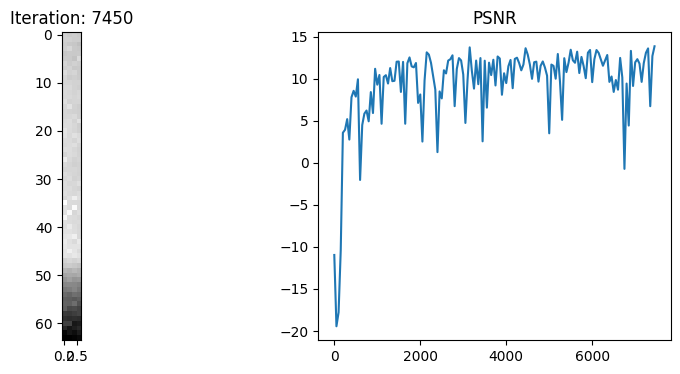

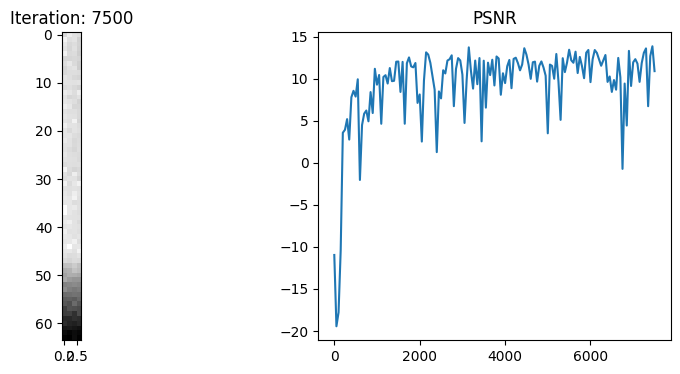

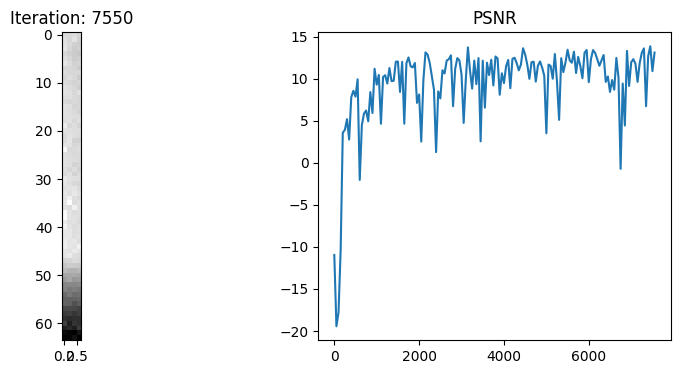

KeyboardInterrupt: 

In [75]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
# optimizer = tf.keras.optimizers.Adam(1e-3) #test-- let's try and overfit
# optimizer = tf.keras.optimizers.Adam(5e-5)

N_samples = 64 #64 #decrease as needed for VRAM
N_iters = 25_000
psnrs = []
iternums = []
i_plot = 50

import time
t = time.time()
for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    
    with tf.GradientTape() as tape:
        #just calculate loss via comparing depth output vs target (should also be depth!)
        depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples, rand=True)
        depth = depth[:,:,None]
        #default loss from TinyNERF
#         loss = tf.reduce_mean(tf.square(depth - target)) 
        #Distance Loss only
        loss = tf.reduce_mean(tf.abs(depth - target)) 
    
        #LiDAR-NeRF LoSS
        ## L_total = L_dist + lam1*L_intensity + lam2*L_raydrop + lam3*L_reg
        ##          lam1=1, lam2=1, lam3=100
        ## L_reg --> restricts loss to 
        
        #-------------------------------------------------------
#         print(loss)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        t = time.time()
        sampl = int(np.random.uniform(low=0, high=len(testpose)-1))        
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose) #constant validation image
#         rays_o, rays_d = get_rays(H, W, focal, testpose[sampl]) #90/10 split
        depth, acc = render_rays(model, rays_o, rays_d, near=1., far=64., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(depth[:,:,None] - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(121)
        p.imshow(depth,cmap = "gray", norm='log')
#         p.set_aspect(2) #test
        p.title(f'Iteration: {i}')
        p.subplot(122)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        p.show()
print('Done')

# Project single inference depth image back to 3D point cloud

In [76]:
# Render the holdout view for logging
look_at = 1

# rays_o, rays_d = get_rays(H, W, focal, poses[look_at])
rays_o, rays_d = get_rays(H, W, focal, testpose) #constant validation image
depth, acc = render_rays(model, rays_o, rays_d, near=1., far=32., N_samples=N_samples)
new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])

depth = tf.transpose(depth).numpy() #test
depth = np.flip(depth, axis = 0) #test

phimin = -0.53529248 #rad
phimax = 0.18622663 #rad

count = 0
for w in range(np.shape(pcs)[1]):
    for h in range(np.shape(pcs)[0]):
        new_point_cloud_spherical[count,0] = depth[w,h] #radius
#         new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/np.shape(depth)[0]) #theta
#         new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/np.shape(depth)[0])/8 #1/8
        new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/np.shape(depth)[0])/16 #1/16
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#transform inference point cloud to map frame using ground truth <testpose>
# new_point_cloud_cart = (new_point_cloud_cart @ testpose[:3,:3]) + testpose[:3,-1]

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# rainbow by z height
zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
disp.append(Points(new_point_cloud_cart, c = cname, r = 5, alpha = 1))
#red
# disp.append(Points(new_point_cloud_cart, c='red',  r = 3.5, alpha =0.5))

# #draw actual scene using another PC
# pcfn = "gazebo_scene2/scan" + str(look_at) + ".npy"
# pc = np.load(pcfn)
# pc[pc[:,0]>100] = 0
# pc[pc[:,0]<-100] = 0
# #transform to constant frame to align the two clouds
# # pc = (pc @ poses[look_at, :3, :3]) + poses[look_at, :3, -1]
# disp.append(Points(pc, c = 'blue', r = 3.5, alpha = 0.5))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Novel Point Cloud From NeRF")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Draw Full Point Cloud From Novel Frame

In [81]:
num_rots = 140 #70 for 1/8th

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for j in range(num_rots):
# for j in np.linspace(0,7,15):
    #get sensor transformation matrix
    rotm = np.eye(4)
    # rotm[0,3] = sensor_pose[i+1,0] #x
    # rotm[2,3] = -sensor_pose[i+1,1] #y
    # rotm[1,3] = -sensor_pose[i+1,2] #z
    # rotm[:3,:3] = R.from_quat(sensor_pose[i+1,3:]).as_matrix() 

    # account for image crop in rotation -------------------
#     crop_angle = -(phimax-phimin)/2 - j*(phimax-phimin)#square
#     crop_angle = -(phimax-phimin)/16 - j*(phimax-phimin)/8 #eighth
    crop_angle = -(phimax-phimin)/32 - j*(phimax-phimin)/16 #1/16
    rotm_crop = R.from_euler('xyz', [0,-crop_angle,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

    #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
    sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #test
    rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
    rotm[2,-1] += 2 #for box #translate all frames above xy plane
    #bring x and y to correct range
    rotm[0,-1] = -1.5
    rotm[1,-1] = 0 #3
    rotm = rotm.astype(np.float32)
    
    start = time.time()
    
    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, focal, rotm)
    depth, acc = render_rays(model, rays_o, rays_d, near=1., far=32., N_samples=N_samples)
    end = time.time()
#     print("inference took:", end-start)
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    phimin = -0.53529248 #rad
    phimax = 0.18622663 #rad

    count = 0
    for w in range(np.shape(pcs)[1]):
        for h in range(np.shape(pcs)[0]):
            new_point_cloud_spherical[count,0] = depth[w,h] #radius
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0])) #theta (square)
#             new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/8 #theta (eighth)
            new_point_cloud_spherical[count,1] = (phimax-phimin)*(w/(np.shape(depth)[0]))/16 #theta (1/16)
            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
            count+= 1

    #account for sweep angle using j
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin) #square
#     new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/8 #eighth
    new_point_cloud_spherical[:,1] -= j*(phimax-phimin)/16 #1/16
            
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

    # rainbow by z height
    zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
    cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
    disp.append(Points(new_point_cloud_cart, c = cname, r = 3, alpha = 0.5))

plt.show(disp, "Novel Point Cloud From NeRF")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# LiDAR-NeRF Regularization

LiDAR-NeRF uses a custom structural regularization to help guide NeRF geometry in low-texture regions.


## Loss Function:
# $\mathcal{L}_{total} = \mathcal{L}_{distance} + \lambda_{1}\mathcal{L}_{intensity}(r) + \lambda_{2}\mathcal{L}_{raydrop}(r) + \lambda_{3}\mathcal{L}_{reg}(r)$

## $\mathcal{L}_{distance}(r) = \Sigma_{r \in R} || \hat{D}(r) - D(r)||_1$

R is the set of all rays, $\lambda$ are the weights for each term

$\lambda_1 = 1, \lambda_2 = 1, \lambda_3 = 1e2$